In [1]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.font_manager as fm
plt.style.use(['science','ieee'])
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
from scipy import optimize as opt


In [2]:
class USM_model:
  def __init__(self, m = 196e-3, d = 500, c = 12e9, cd = 10e-9, rd = 1e-6, A = 0.3,
               h =  4e-3, r = 30e-3, k_r = 4e7, mu = 0.2,v_amp = 175, F_n = 170,
               T = 0, phase =np.pi/2, tempMin = 20,  r_b = 30e-3, r_a = 15e-3,l = 15e-3,
               ru = 8400, sigma = 5.67e-8, h_c = 60, e = 0.8, s = 0.5e3, dt = 0,
              freq = 40, temp = 20, targetSpeed = 100, N = 9,v_amp_def=175):

   
    self.C = c                            # Modal Mass
    self.D = d                            # Modal Damping
    self.M = m                            # Modal Stiffness
    self.Cd = cd                          # Damped Capacitance
    self.A00 = A                           # Coupling Factor
    self.N = N                            # Vibration Mode
    self.Mu = mu                          # Friction Coefficient
    self.k_r = k_r                        # Rotor Stiffness
    self.rd = rd                          # Damped Resistance
    self.r = r                            # Stator Radius
    self.h = h                            # Height of contact surface
    self.tempMin = tempMin                # Ambient Temperature
    self.temp = temp                      # Current Temperature
    self.dt = dt                          # Time Step 
    self.targetSpeed = targetSpeed        # Initial target speed
    self.v_amp_def   = v_amp_def          # Default Voltage Amplitude 

    # Heat Trasnfer Parameters
    self.sigma = sigma                    # Boltezman constant             
    self.e = e                            # Emissivity
    self.s  = s                           # Heat Capacitance
    self.h_c = h_c                        # Convection Coefficient

    self.area = 2*np.pi*((r_b+r_a)*l + (r_b**2 - r_a**2)) # Stator Area
    self.mass = ru*np.pi*(r_b**2-r_a**2)*l              # Stator Mass

    # Control Variables
    self.freq = freq                      # Driving Frequency
    self.v_amp = v_amp                    # Voltage Amplitude
    self.F_n = F_n                        # Preload
    self.T = T                            # Load Torque
    self.phase = phase                        # Phase Difference

    # Zero initialization 
    self.theta = 0
    self.lastTheta = 0
    self.targetTheta = 0
    self.lastSpeed = 0.0
    self.err = 0
    self.freq_action = 0
    self.pLoss = 0.0
    self.speed_noise = 0
    self.action_noise = 0
    
    self.vary_param(np.zeros(6))

    # Setup the min-max scaler for input-state

    # State ==> -- freq ,torque, FBV ,speed    
    self.max_scaler = np.array([45, 60 , 1, 300, np.pi/2 , 180])
    self.min_scaler = np.array([39, 20 , 0, -300, -np.pi/2, -180])
    self.mean_scaler = (self.max_scaler + self.min_scaler)/2

  def scale_obs(self,o):
      return (o - self.mean_scaler)/(self.max_scaler - self.min_scaler)*2

  # Sample from Beta dist [0-1] and rescale [x_min,x_max]
  # (0.7,0.7) params give higher sampling rate of extreme states
  def sample_beta(self, x_min,x_max,a=0.8,b=0.8):
    return x_min + np.random.beta(a,b)*(x_max-x_min)


  # Sample from a unifrom dist with some extension and clip
  def sample_uniform(self,x_min,x_max,extend=0.01):
    x = x_min + (-extend+np.random.random()*(1+2*extend))*(x_max-x_min)
    return np.clip(x,x_min,x_max)

  # Temperature model
  # 1) Estimate heat trasnfer from convection (h*A*dT) and radiation 
  # 2) The temperature rise is calcuated from heat capacity, mass.
  def update_temp(self,pLoss=None):
    #self.h_c = self.h_c_0 + 1*(self.v_amp - self.v_amp_def) 
    if pLoss == None:
      pLoss = self.pLoss
    #pCond = 50*self.contact_area/10e-3*(self.temp - 25)
    pConv = self.h_c*self.area*(self.temp-self.tempMin)
    pRad  = self.sigma*self.e*self.area*((self.temp+273)**4 - (self.tempMin+273)**4)
    powerFlow = pLoss - pConv #- pRad
    tempRate = powerFlow/self.mass/self.s
    self.temp += self.dt*tempRate
    self.temp = np.clip(self.temp,self.tempMin,60)
    return self.get_state()


  # Optimization function for vibration amplitude
  # 1) Calculate rotor height (wf) and contact angle (thetaB)
  # 2) Calculate slip/stick angle (thetaA)
  # 3) Calculate contact forces (F_N, F_T) 
  # 4) Return energy error. 
  def func_amp(self,w0,*args):
    return_all, = args
    if w0 < -self.wf:
      theta_b = np.pi
      wf = self.wf
    else:
      theta_b = opt.brenth(self.func_thetaB,1e-7,np.pi,args=(w0))
      wf = w0*np.cos(theta_b)
    try:  
      theta_a = opt.brenth(self.func_thetaA,1e-7,np.pi/2,args=(w0,theta_b,wf))
    except:
      theta_a = np.pi/2
    F_N = self.k_r*(w0*(np.sin(2*theta_b)/2 + theta_b) - 2*wf*np.sin(theta_b))
    F_T = 2*self.N*self.mu*self.k_r*(self.h/self.r) *\
          (w0*(np.sin(2*theta_a)/2 -np.sin(2*theta_b)/4 + theta_a - theta_b/2) -\
          wf*(2*np.sin(theta_a)-np.sin(theta_b)))
    err= (self.A*self.v_amp)**2 - ((self.c-self.m*self.omega**2)*w0 + F_N)**2 -\
                                  (self.d*self.omega*w0 + F_T)**2
    if return_all:
      return [theta_a, theta_b, wf, F_N, F_T, err]
    else:
      return err 
  
  # Optimization function for slip/stick angle (thetaA)
  def func_thetaA(self,theta_a,*args):
    w0,theta_b,wf = args
    return self.T+self.T_max -\
     4*self.mu*self.k_r*self.r*(w0*np.sin(theta_a)-wf*theta_a)

  # Optimization function for contact angle (thetaB)
  def func_thetaB(self,theta_b,*args):
    w0, = args
    return self.F_n -\
     2*self.k_r*w0*(np.sin(theta_b)-theta_b*np.cos(theta_b))

  # Get system state at a given frequency
  def get_state(self,freq=None,return_all = False):
    
    # Get frequency and anuglar frequency
    if freq != None:    
        self.freq = freq
    freq_noise = self.freq + self.action_noise*np.random.normal(0,1)
    self.omega = 2*np.pi*(freq_noise)*1000

    # Update temperature dependent parameters
    self.c = self.c0*(1-0.0075*np.sqrt(self.temp-self.tempMin))
    self.d = self.d0*(1-0.04*np.sqrt(self.temp-self.tempMin) + 0.0145*(self.v_amp-self.v_amp_def))

    self.m = self.m0

    # Calculate vibration amplitude through bounded optimization
    self.wf = -self.F_n/(2*np.pi*self.k_r)
    omega_n = np.sqrt((self.c + np.pi*self.k_r)/self.m)

    self.w0,r = opt.brenth(self.func_amp,1e-9,1e-5,args=(False),full_output=True)
    # Calculate other states given vibration amplitude
    self.theta_a, self.theta_b, self.wf, self.F_N, self.F_T, err = self.func_amp(self.w0,True)
    # Hardcode hystresis based on last state
    cond = ~((self.omega < (1.02 - 0.00025*(self.v_amp-self.v_amp_def) - 0.00125*(self.temp - self.tempMin))*omega_n) & (np.abs(self.lastSpeed) < 1e-50))
    self.w0 = self.w0*cond 

    phi_int = self.T/self.T_max*np.pi/2
    phi_x = (np.abs(self.phase)-phi_int)/(np.pi/2-phi_int + 0.001)*np.pi/2

    self.speed = self.N*60*self.omega*self.h*self.w0/(2*np.pi*self.r**2)*np.cos(self.theta_a)*(self.F_n > 0)* (self.T < self.F_n*self.mu*self.r)*np.sin(np.sign(self.phase)*np.maximum(0,phi_x))
    self.lastSpeed = self.speed
    theta0 = np.arctan2(self.d*self.omega*(self.w0 + 0.2e-6*~cond) + self.F_T, (self.c-self.m*self.omega**2)*(self.w0 + 0.2e-6*~cond) + self.F_N)
    if abs(err) > 1:
      print('freq: {}, speed: {}, FN: {}, FT: {}, w0: {}, wf: {},  theta_a: {}, err: {}'.format(freq,self.speed,self.F_N,self.F_T,self.w0,self.wf,self.theta_a,err))
    I = 1j*self.omega*(self.w0 + 0.2e-6*~cond)*np.exp(-1j*theta0)*self.A + (self.rd + 1j*self.omega*self.cd)*self.v_amp
    I_real = self.omega*self.A*(self.w0 + 0.2e-6*~cond)*np.sin(theta0) + self.rd*self.v_amp
    I_img = self.omega*(self.A*(self.w0 + 0.2e-6*~cond)*np.cos(theta0) + self.cd*self.v_amp)
    I_amp = np.abs(I)/np.sqrt(2)
    I_phase = (np.angle(I,deg=True)  + 2 * 180) % (2 * 180)
    pIn = 2*(self.v_amp/np.sqrt(2))*I_amp*np.cos(I_phase*np.pi/180)
    pOut = (self.speed/60*2*np.pi)*self.T
    FBV = (self.w0 + 0.2e-6*~cond)*self.A/self.cd/np.sqrt(2)#self.w0*self.A/self.cd*np.
    self.eff = pOut/pIn*100
    self.pLoss = pIn - pOut
    # Add noise to speed measurements
    speed_noise = self.speed + self.speed_noise*np.random.normal(0,1)
    self.speed = round(speed_noise,2)


    if return_all:
      return np.array([self.theta_a, self.speed, self.w0, FBV , I_phase, pIn, I_amp, self.eff])
    else:
      return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])

  def update_pos(self):
    dist = self.speed/60*360*self.dt
    self.extra_rotations = (dist // 360)
    self.theta = ((self.lastTheta + dist) + 360)%360 
    self.err = ((self.targetTheta - self.theta) + 360)%360
    self.err = self.err - 360 if self.err > 180 else self.err

    self.lastTheta = self.theta

    return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])


  #Use an estimate of Control Lyapunov Function as a reward
  def get_reward(self,action):
    #Higher lambda -> Faster Response / Less Robustness 
    lam = 2   # [1-5]
    L = self.energyDiff + lam*self.lastEnergy
    return 1*lam - L 

  # Reset the environment at the start of every episode
  # Use a beta distribution to increase propability of sampling edge cases for better robustness
  # Sample initial frequency - load torque - temperature - target speed
  # lastW0 -- determines the speed hystresis -- default: the motor is at stall
  def reset(self,freq=None,temp=None, phase = None, lastSpeed = 0, T = None, theta = None, targetTheta=None, return_all = False):
    self.lastSpeed = lastSpeed
    self.freq = self.sample_beta(39,45) if freq == None else freq
    self.temp = self.sample_beta(20,60) if temp == None else temp
    self.targetTheta = 360*np.random.random() if targetTheta == None else targetTheta
    self.theta = 360*np.random.random() if theta == None else theta
    self.phase = self.sample_beta(-np.pi/2,np.pi/2) if phase == None else phase
    self.T = self.sample_beta(0,1) if T == None else T
    self.get_state()

    self.err = ((self.targetTheta - self.theta) + 360)%360
    self.err = self.err - 360 if self.err > 180 else self.err
    self.lastTheta = self.theta    
    self.lastEnergy =  1/np.log(181)*np.log(np.abs(self.err)+1)
    
    return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])

 


  # Update the driving frequency given the frequency action
  # Clip the frequency within the limits
  # Update the system state and the temperature
  # Calculate the energy based on speed error (Neccessary for reward)
  def step_frequency(self,action):          
      self.freq = self.freq + action[0]*2
      self.freq = np.clip(self.freq,39,45)

      self.phase = self.phase + action[1]*np.pi
      self.phase = np.clip(self.phase,-np.pi/2,np.pi/2)

      
      state = self.get_state(self.freq)
      state = self.update_temp()
      state = self.update_pos()


      energy =   1/np.log(181)*np.log(np.abs(self.err)+1)
      self.energyDiff = energy - self.lastEnergy
      self.lastEnergy = energy

      return state, self.get_reward(action[0]*2)

  # Vary some USM parameters under a normal distribuation
  # Useful for studying the robustness of the controller to motor variations
  def vary_param(self,vars=[]):
    if not len(vars):
      vars = np.clip(np.random.normal(0,1,size=(6,)),-1,1)

    self.A0 = self.A00*(1+0*.05*vars[0])
    self.A = self.A0
    self.c0 = self.C*self.A**2*(1+0.01*vars[1])
    self.d0 = self.D*self.A**2*(1+0.1*vars[2])
    self.m0 = self.M*self.A**2*(1+0.01*vars[3])
    self.cd = self.Cd*(1+0*.05*vars[4])
    self.mu = self.Mu*(1+0*.05*vars[5])

    self.T_max = self.F_n*self.mu*self.r

    params = np.array([self.A,self.c0,self.d0,self.m0,self.cd,self.mu])
    return params, vars
    
  # Set noise levels on input and output to test controller robustness
  def set_noise(self,speed_noise,action_noise):
    self.speed_noise = speed_noise
    self.action_noise = action_noise 
  
  # Return system state under changes in target speed or torque
  def set_state(self,targetTheta=None,theta = None, torque = None):
    if targetTheta != None:
      self.targetTheta = targetTheta
    if theta != None:
      self.theta = theta
      self.lastTheta = theta
    if torque != None:
      self.T = torque
    self.get_state()
    self.err = ((self.targetTheta - self.theta) + 360)%360
    self.err = self.err - 360 if self.err > 180 else self.err  
    return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])

  # Setters and getters to access the USM class variables
  def set_temp(self,temp):
    self.temp = temp
  def get_temp(self):
      return self.temp

  def get_torque(self):
      return self.T
  def set_torque(self,T):
      self.T = T
  def get_phase(self):
      return self.phase

  def get_targetTheta(self):
      return self.targetTheta
  def get_theta(self):
      return self.theta
  

  def get_targetSpeed(self):
      return self.targetSpeed
  def get_speed(self):
      return self.speed


0
0.1
0.2
0.5
0.7
0.8
1


Text(0, 0.5, 'Driving Efficiency [%]')

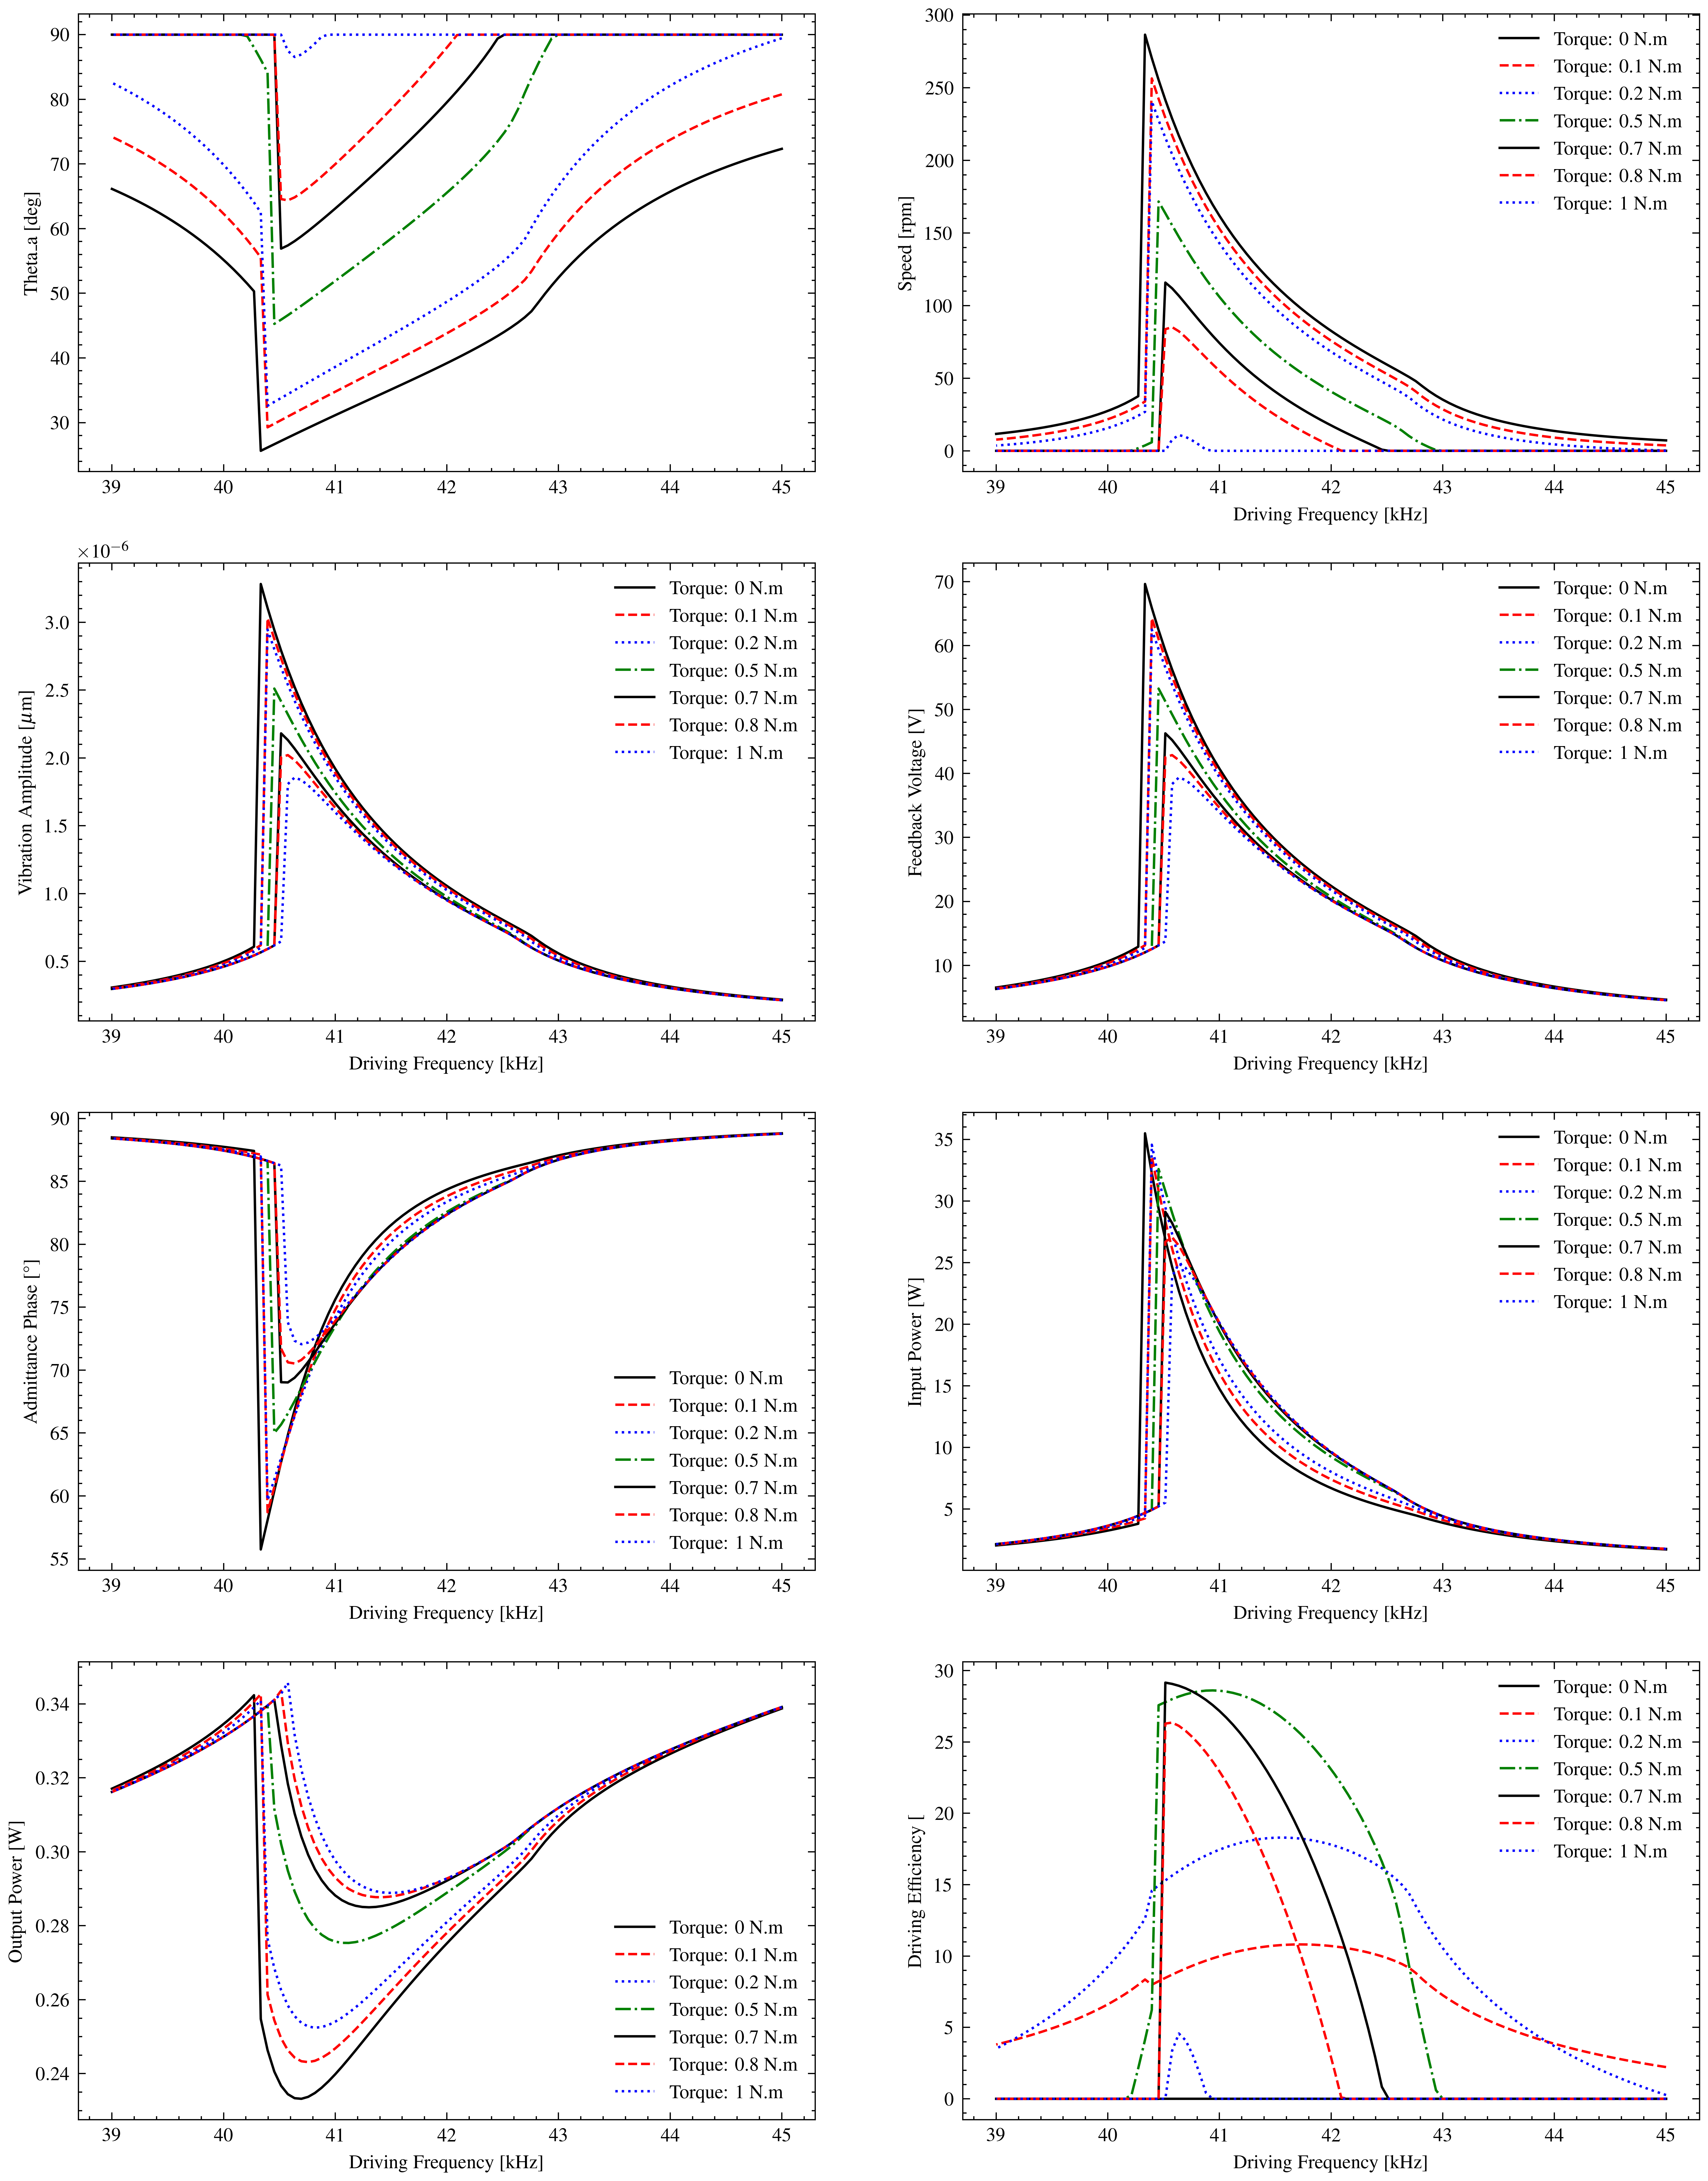

In [3]:
# View Different States Under Varying Torque

def sweep_freq(USM,freqs,return_all = False):
  states = []
  for freq in freqs:
    states.append(USM.get_state(freq,return_all))
  return np.array(states)
  
fig, axs = plt.subplots(4, 2,figsize=(12,16))
freqs = np.linspace(45,39,100)
for T in [0,0.1,0.2,0.5,0.7,0.8,1]:
  print(T)
  USM = USM_model(T=T)
  states = sweep_freq(USM,freqs,return_all=True)
  axs[0,0].plot(freqs,states[:,0]*180/np.pi, label='Torque: {} N.m'.format(T))
  for i in range(1,states.shape[1]):
    axs[i//2,i%2].plot(freqs,states[:,i], label='Torque: {} N.m'.format(T))
    axs[i//2,i%2].legend()
    axs[i//2,i%2].set_xlabel('Driving Frequency [kHz]')
#axs[0,0].legend()
axs[0,0].set_ylabel('Theta_a [deg]')
axs[0,1].set_ylabel('Speed [rpm]')
axs[1,0].set_ylabel('Vibration Amplitude [$\mu$m]')

axs[1,1].set_ylabel('Feedback Voltage [V]')
axs[2,0].set_ylabel('Admittance Phase [°]')
axs[2,1].set_ylabel('Input Power [W]')
axs[3,0].set_ylabel('Output Power [W]')
axs[3,1].set_ylabel('Driving Efficiency [%]')

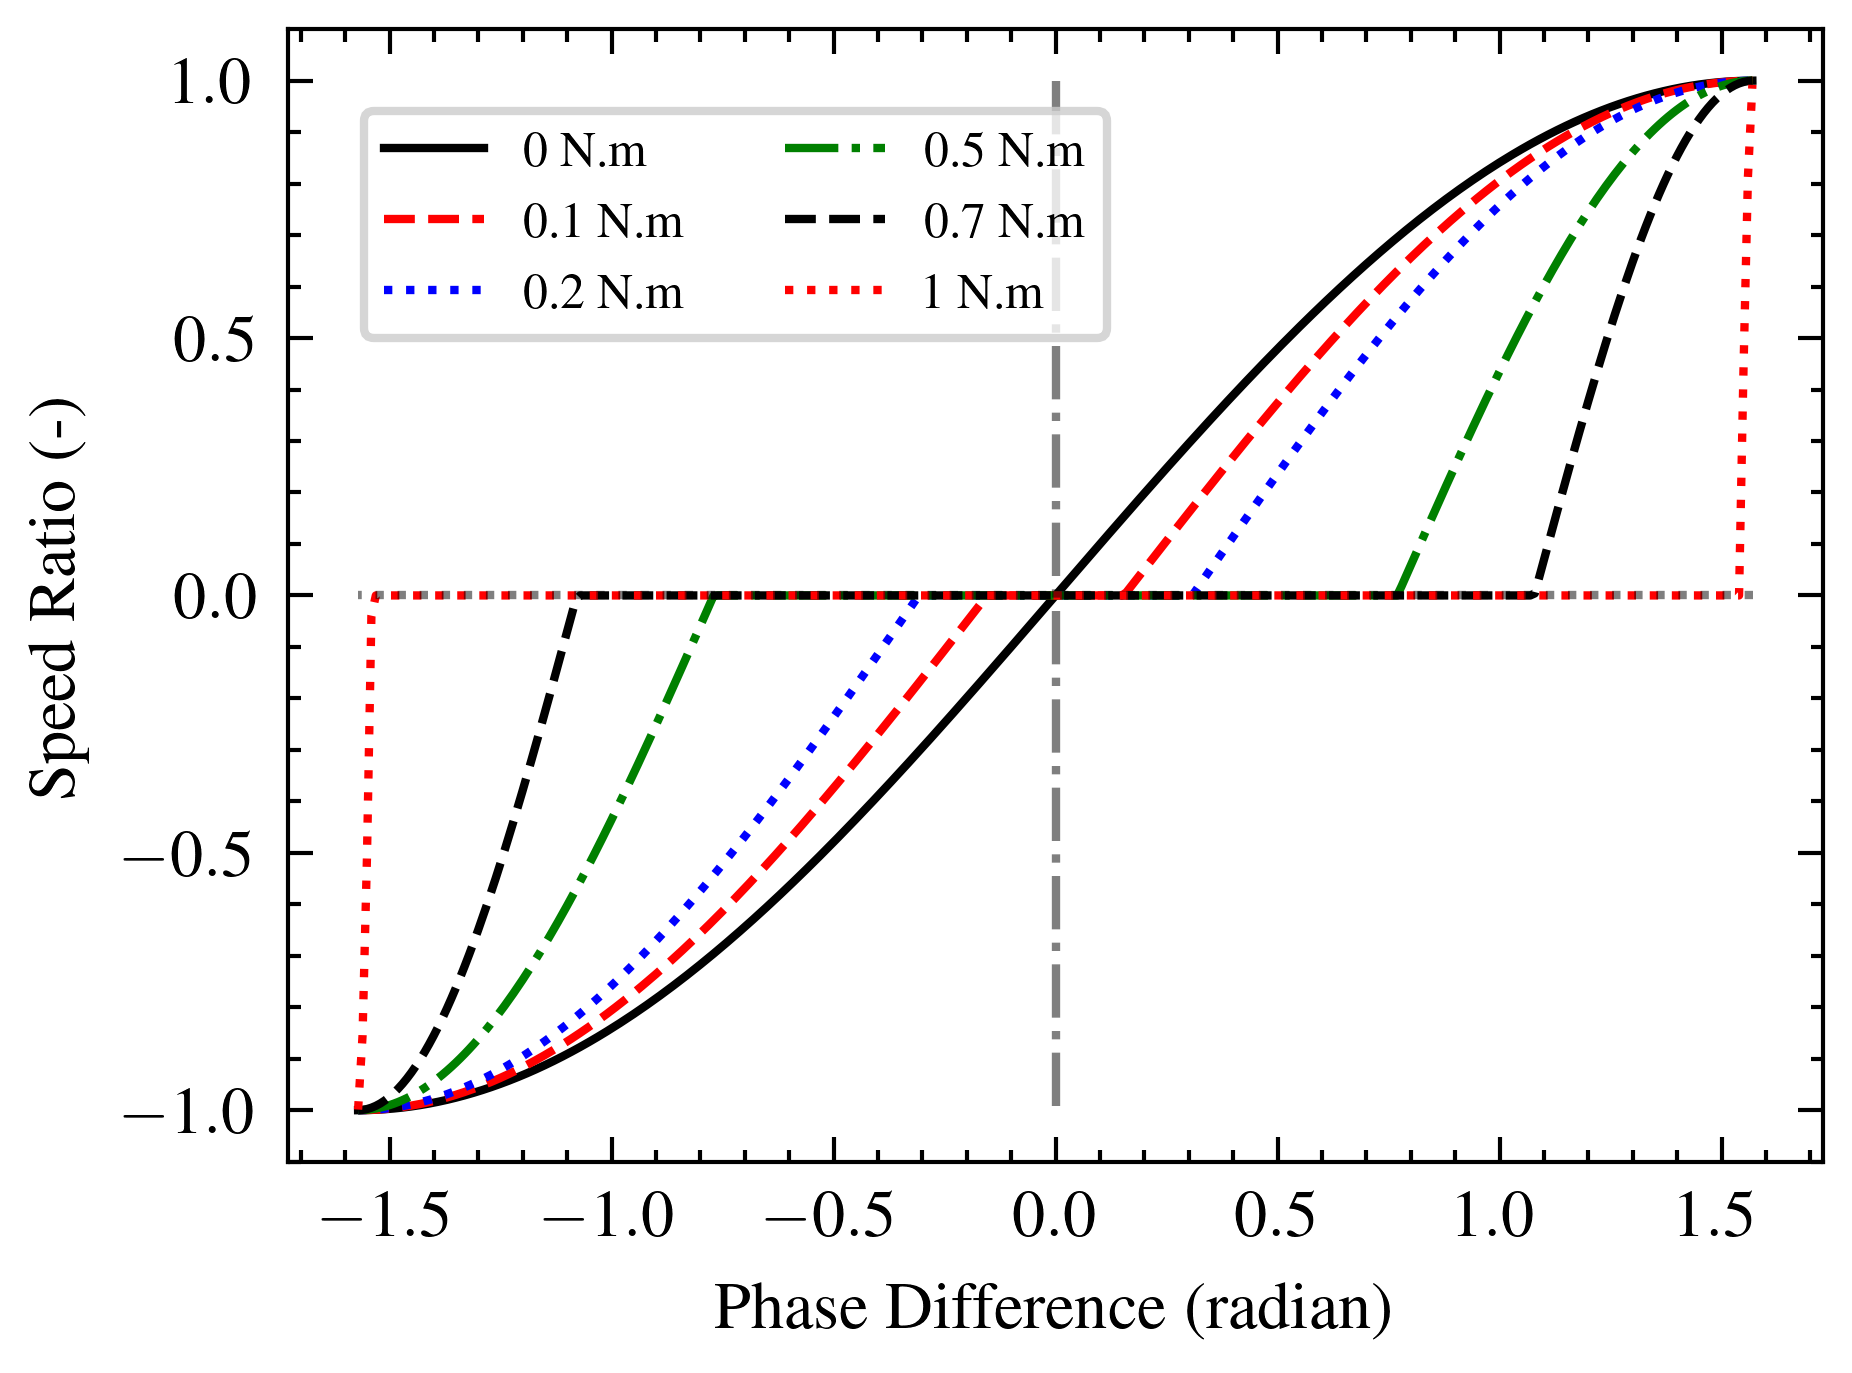

In [3]:
lineType = ['-','--',':','-.','--',':']

def get_Z(phi, T=None):
  T_max = 1.02
  phi_dead = T/T_max*np.pi/2
  phi_x = (np.abs(phi)-phi_dead)/(np.pi/2-phi_dead + 0.001)*np.pi/2
  return np.sin(np.sign(phi)*np.maximum(0,phi_x))
#0 >> 0 -- T_max >> np.pi/2 -- phi_int = T/T_max*np.pi/2  -- phi_int >> 0 -- pi/2 >> pi/2   --  (x - pi_int)/phi_x = (pi/2 - phi_int)/(pi/2) >> phi_x = (x-phi_int)/(pi/2-phi_int)*pi/2
x = np.arange(-np.pi/2,np.pi/2,0.01)
i = 0
for T in [0,0.1,0.2,0.5,0.7,1]:
  plt.plot(x,get_Z(x,T),lineType[i],label="{} N.m".format(T))
  i += 1
plt.plot([np.pi/2,-np.pi/2],[0,0],'k',alpha=0.5)
plt.plot([0,0],[1,-1],'k',alpha=0.5)
plt.xlabel('Phase Difference (radian)')
plt.ylabel('Speed Ratio (-)')

plt.legend(loc="upper right",bbox_to_anchor=(0.55,0.95),frameon = True, ncol=2,prop={'size': 6})

plt.savefig('plots/phase_control_effect_sim.pdf')
plt.savefig('plots/phase_control_effect_sim.jpeg')



20 0.0
30 0.0
40 0.0
50 0.0
60 0.0


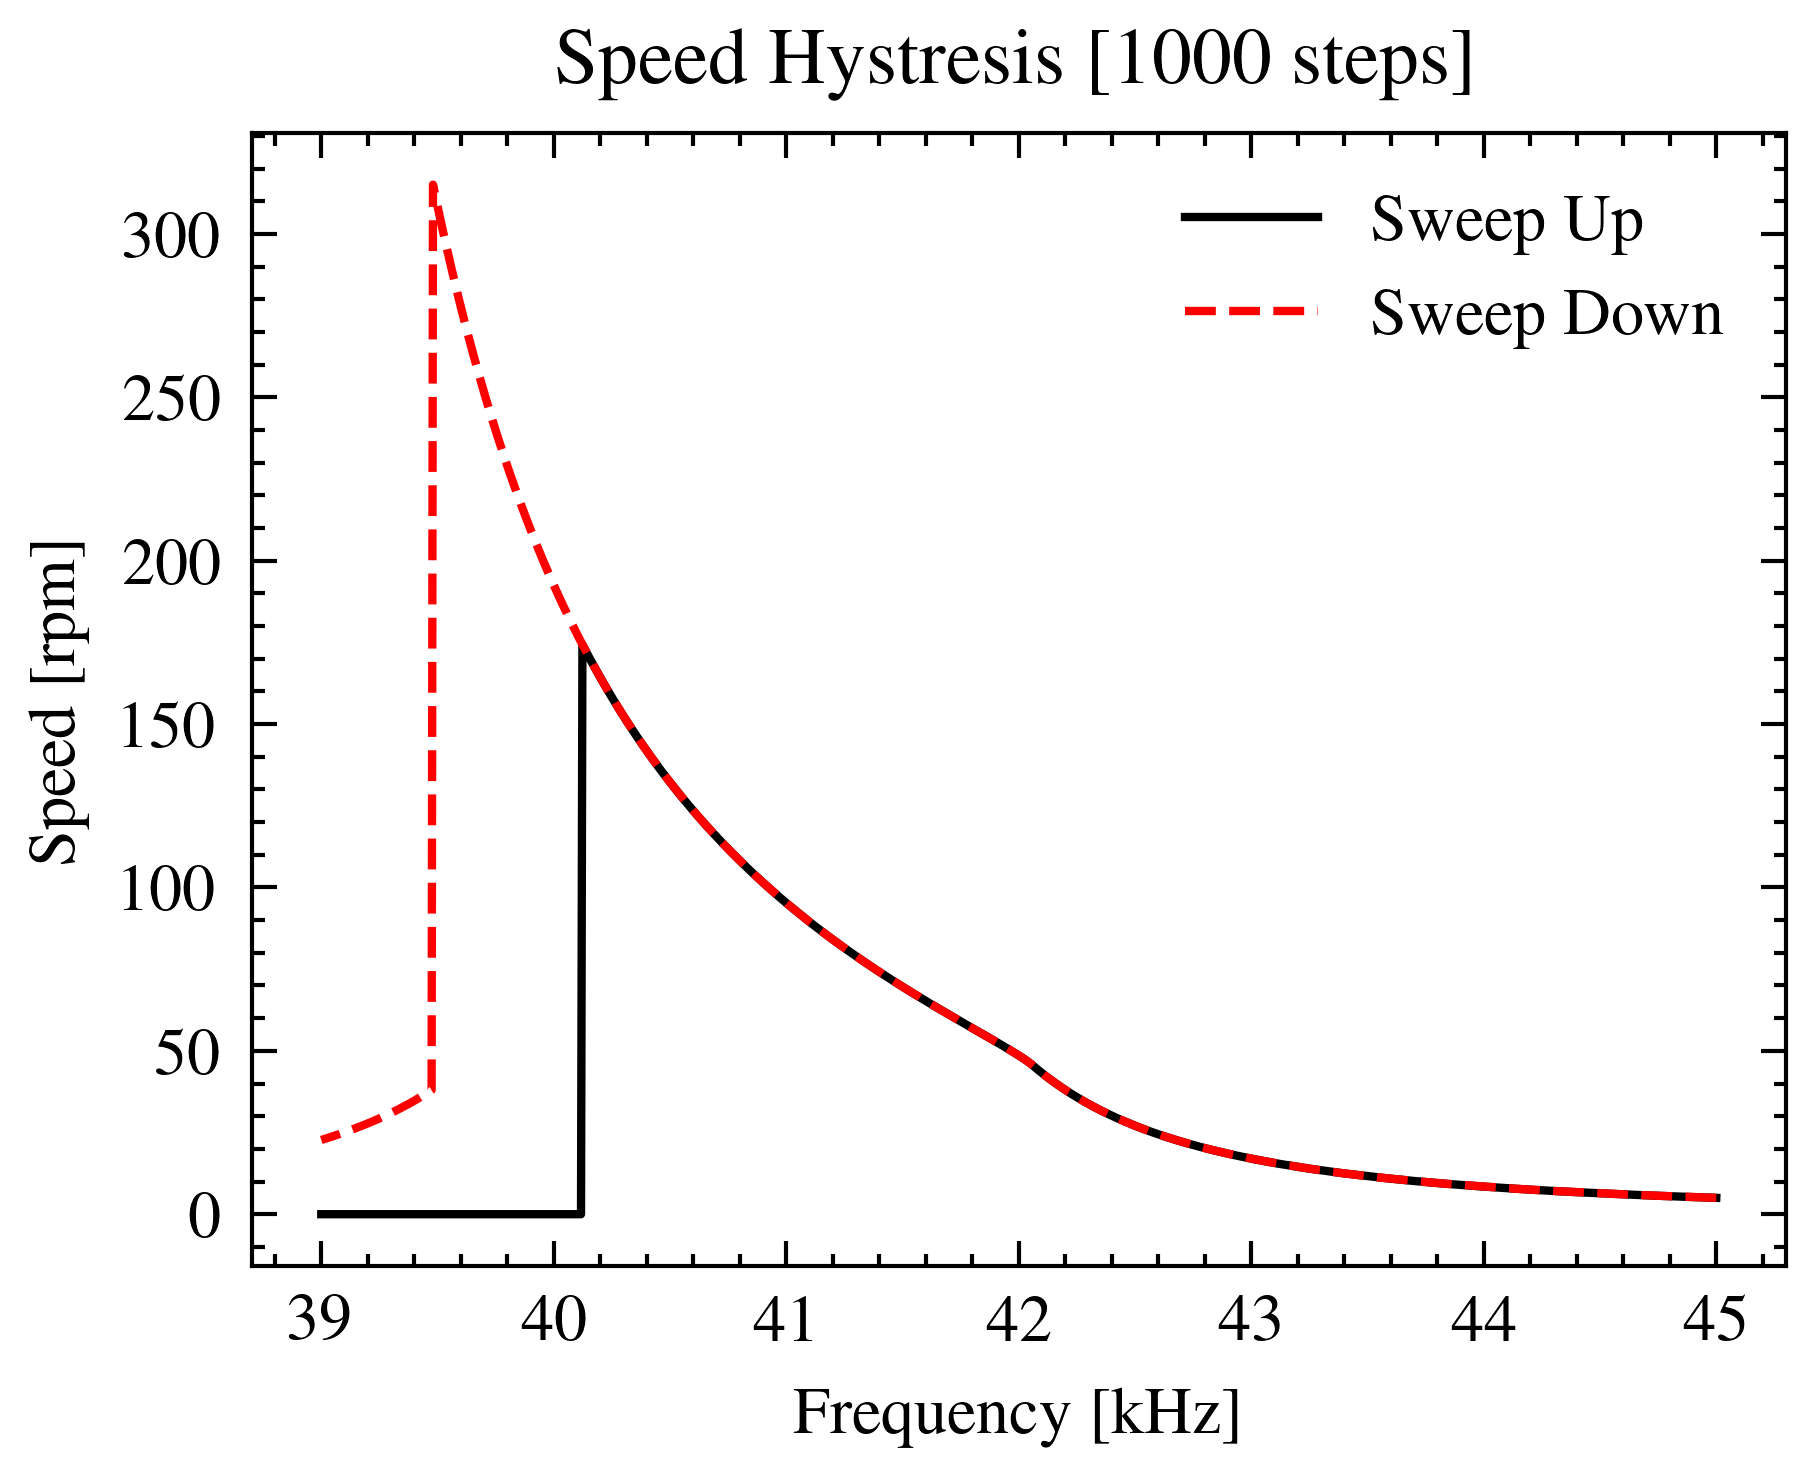

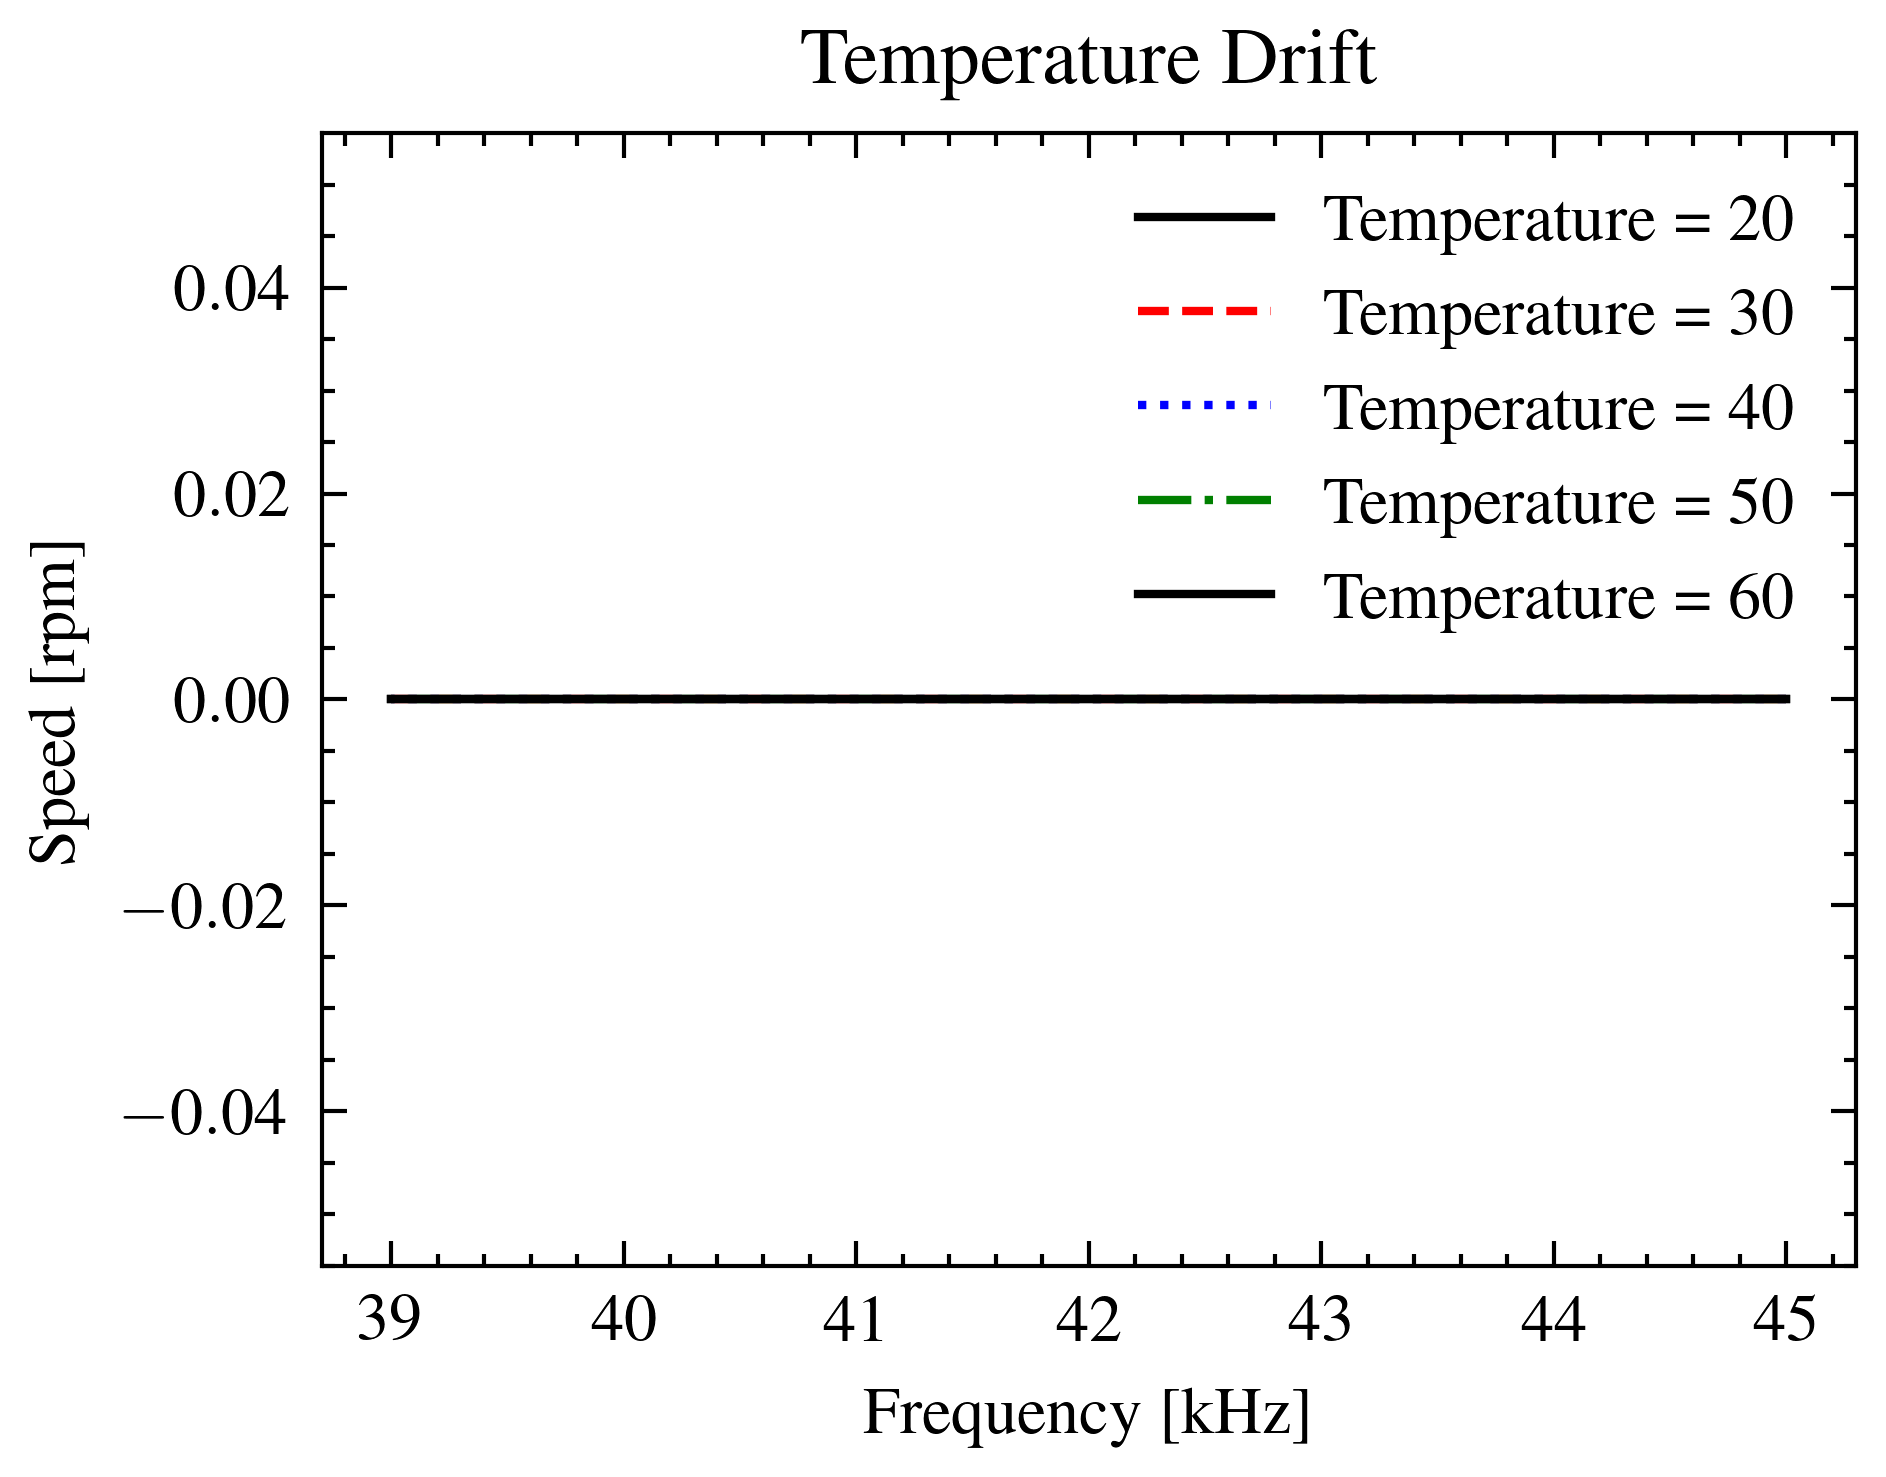

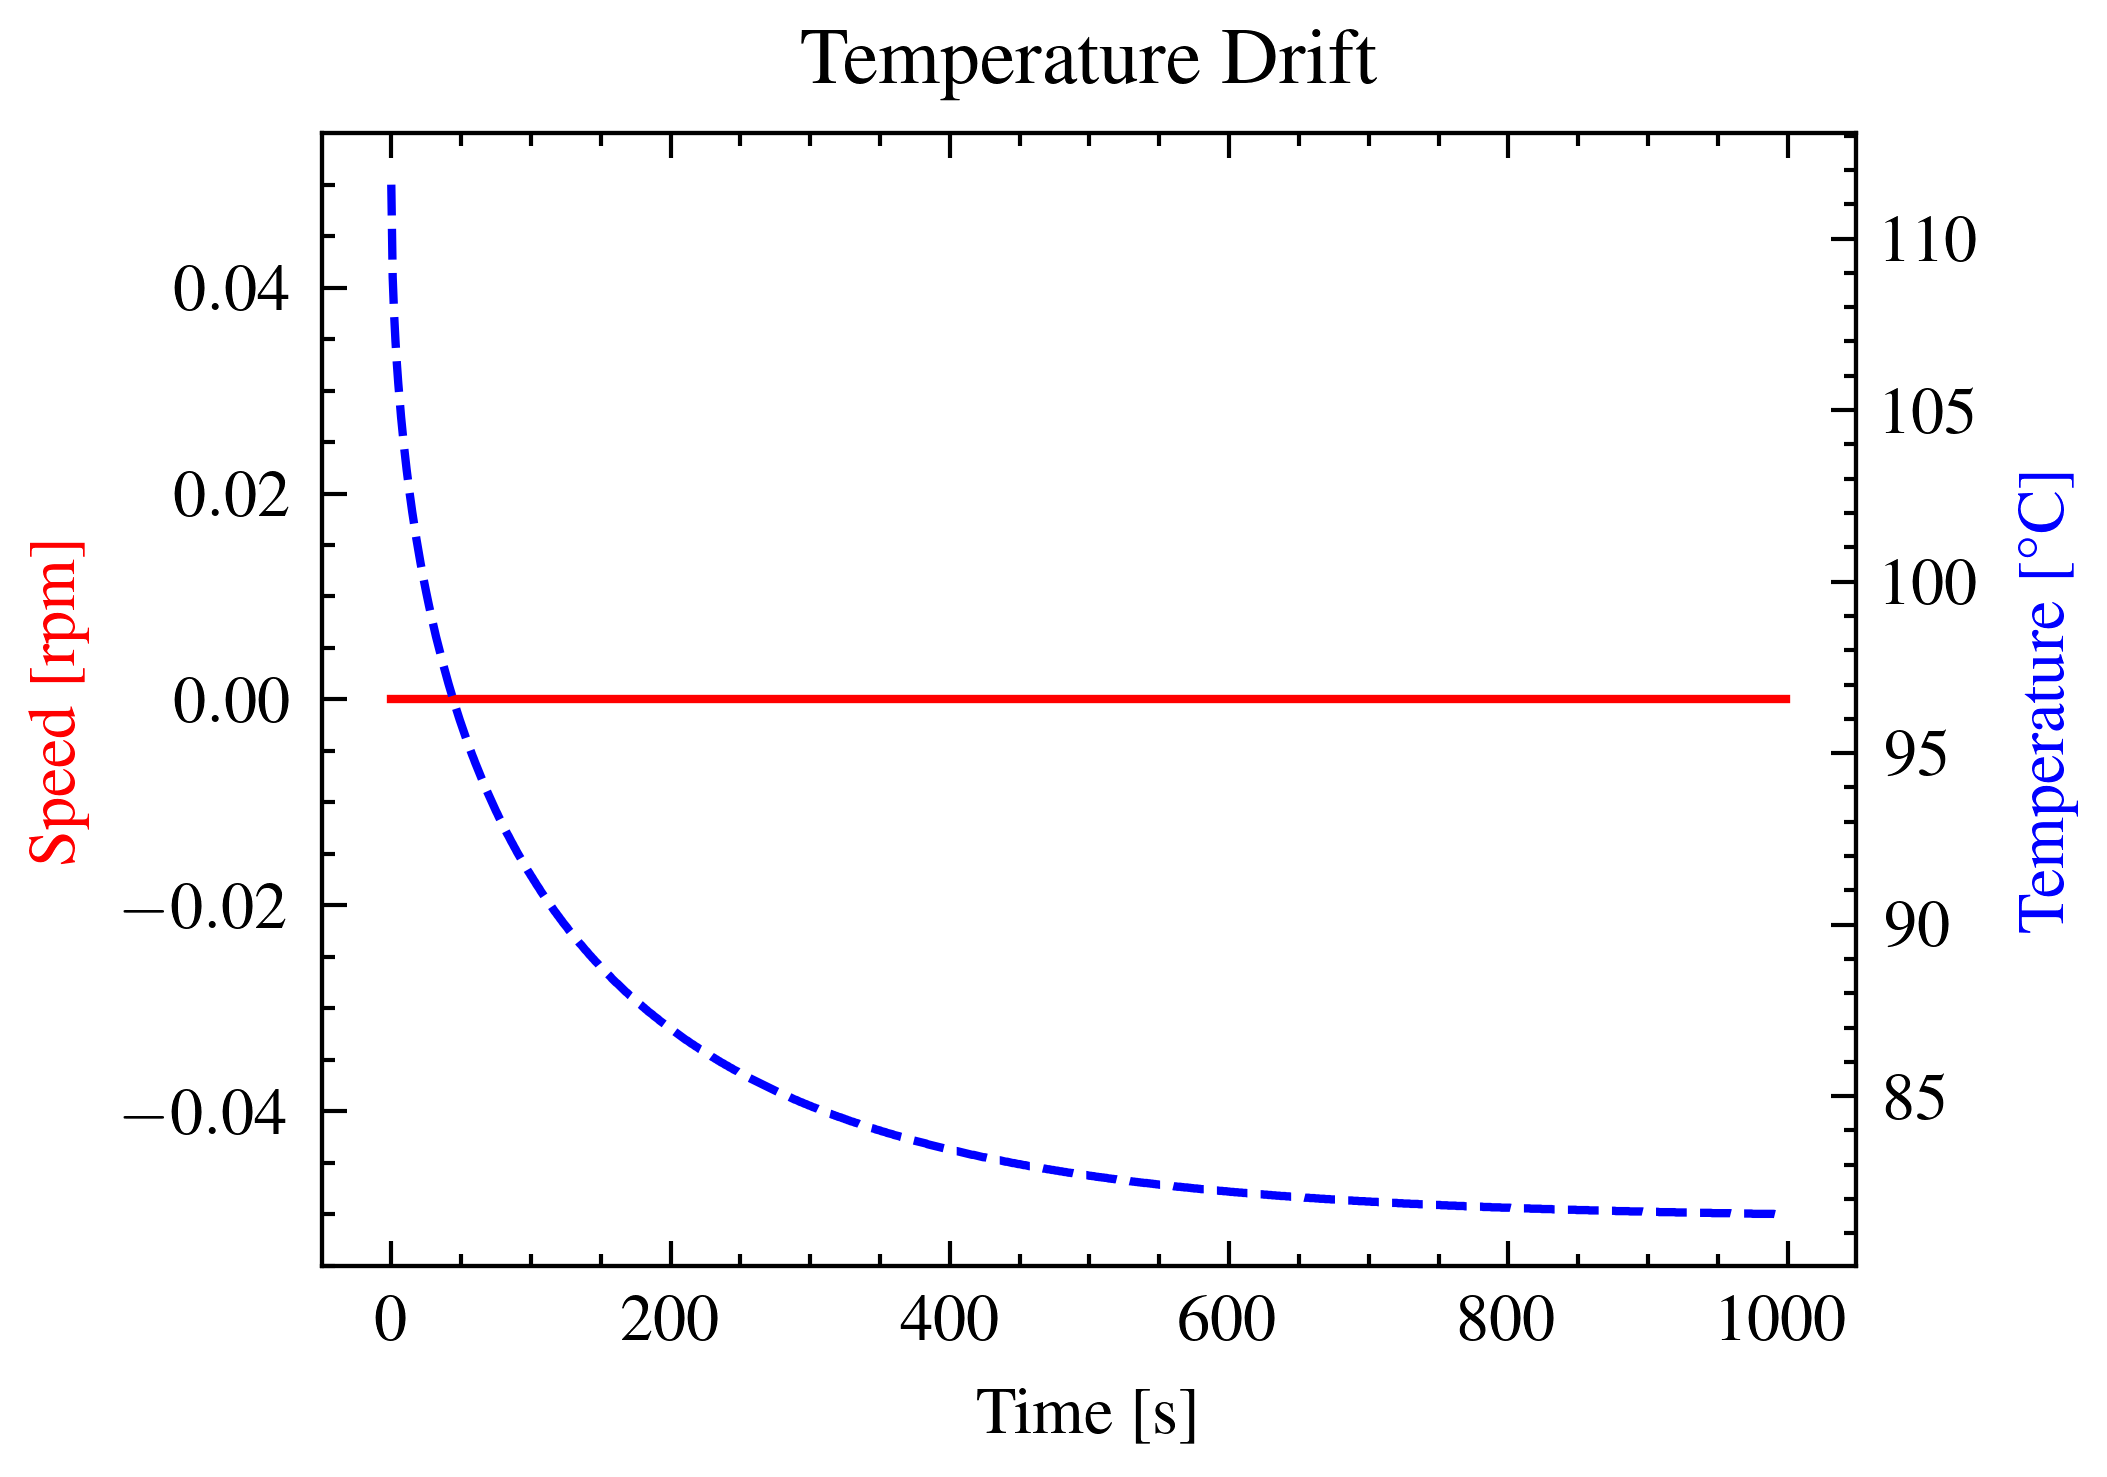

In [6]:
USM = USM_model(T=0, temp=50)

n = 1000
freqs_up = np.linspace(39,45,n) 
freqs_down = np.linspace(45,39,n) 

speeds_up = sweep_freq(USM,freqs_up)[:,3]
speeds_down = sweep_freq(USM,freqs_down)[:,3]
plt.figure()
plt.plot(freqs_up,speeds_up,label='Sweep Up')
plt.plot(freqs_down,speeds_down,label='Sweep Down')
plt.xlabel('Frequency [kHz]');
plt.ylabel('Speed [rpm]');
plt.title('Speed Hystresis [' + str(n) + ' steps]');
plt.legend();

USM = USM_model(T=0.)

freqs = np.linspace(45,39,1000)
temps = [20,30,40,50,60]
plt.figure()
for temp in temps:
  USM.set_temp(temp)
  speeds = sweep_freq(USM,freqs)[:,2]
  print(temp,max(speeds))
  plt.plot(freqs,speeds,label='Temperature = ' + str(temp))
plt.xlabel('Frequency [kHz]');
plt.ylabel('Speed [rpm]');
plt.title('Temperature Drift');
plt.legend();

dt = 1
USM.dt = dt
t = 0
speeds = []
times = []
temps = []
freq = 41.5
USM.reset(temp=20,freq=freq,T=0,lastSpeed=1)
for i in range(1000):
  state = USM.get_state()
  speed,temp = state[2],state[3]
  temps.append(temp)
  speeds.append(speed)
  times.append(t)
  USM.update_temp()
  t+= dt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(times, speeds, 'r-')
ax2.plot(times, temps, 'b--')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Speed [rpm]', color='r')
ax2.set_ylabel('Temperature [°C]', color='b')
ax1.set_title('Temperature Drift')
plt.show()


In [30]:
from numpy.core.fromnumeric import repeat
import pickle
"""## Soft Actor Critic
#### Spinningup Implementation

This code was based on the spinningup implementation of SAC in Pytorch
"""

# Import important Libraries
# Pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.optim import Adam

import numpy as np
from copy import deepcopy   #copy neural network objects
import itertools

# Return appropiate Shape for the replay buffer arrays
def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

# A general multi-layer-perceptron network structure
def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)



'''
Soft Policy (Actor) Class
Given a state, the network outputs the mean and standard deviation used to sample
the action from a gaussian distribution. The action is squashed using tanh function.
For a sampled action, the log probiblity is calculated under the squashed gaussian.  
'''
class SquashedGaussianMLPActor(nn.Module):
    
    # Initialize Class using Pytorch nn.Module super class
    # The mu_layer and log_std_layer share the same starting layer net
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        self.net = mlp([obs_dim] + list(hidden_sizes), activation, activation)
        self.mu_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.act_limit = torch.as_tensor(act_limit, dtype=torch.float32)

        # Limits for clipping the log std of the action
        self.LOG_STD_MAX = 2
        self.LOG_STD_MIN = -20

    # Define the forward function 
    # In case of policy evaluation (deterministic) -- Only the mean action is outputed.
    # During training, the action is normally sampled for better exploration
    # The log probability is calculated from the gaussian distribution taking into account
    # the tanh squashing
    def forward(self, obs, deterministic=False, with_logprob=True):
        net_out = self.net(obs)
        mu = self.mu_layer(net_out)
        log_std = self.log_std_layer(net_out)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        std = torch.exp(log_std)

        # Pre-squash distribution and sample
        pi_distribution = Normal(mu, std)
        if deterministic:
            # Only used for evaluating policy at test time.
            pi_action = mu
        else:
            pi_action = pi_distribution.rsample()

        if with_logprob:
            # Compute logprob from Gaussian, and then apply correction for Tanh squashing.
            # NOTE: The correction formula is a little bit magic. To get an understanding 
            # of where it comes from, check out the original SAC paper (arXiv 1801.01290) 
            # and look in appendix C. This is a more numerically-stable equivalent to Eq 21.
            # Try deriving it yourself as a (very difficult) exercise. :)
            logp_pi = pi_distribution.log_prob(pi_action).sum(axis=-1)
            logp_pi -= (2*(np.log(2) - pi_action - F.softplus(-2*pi_action))).sum(axis=-1)
        else:
            logp_pi = None

        # Squash and scale the action
        pi_action = torch.tanh(pi_action)
        pi_action = self.act_limit * pi_action

        return pi_action, logp_pi

'''
Critic Class
Given a state and action, the network outputs the Q-value (expected discounted future total reward)
'''
class MLPQFunction(nn.Module):
    # Initialize Class using Pytorch nn.Module super class
    # Use multi-head output to regularize the output Q
    # Faster training compared to using multiple Q-networks.
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation,n_outputs=10):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [n_outputs], activation)

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1))
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

'''
Actor-Critic Class
Combines the actor network, the critic network, and a network for speed estimation. 
'''
class MLPActorCritic(nn.Module):


    def __init__(self, obs_dim, act_dim, act_limit, hidden_sizes=((64,64),(64,64)),
                 activation=(nn.ReLU,nn.ReLU)):
        super().__init__()

        # build policy and value functions
        self.pi = SquashedGaussianMLPActor(obs_dim, act_dim, hidden_sizes[0], activation[0], act_limit)
        self.q = MLPQFunction(obs_dim, act_dim, hidden_sizes[1], activation[1])
        
    # Take actions to collect experiences (no gradient is calculated)
    def act(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32)
        with torch.no_grad():
            a, _ = self.pi(obs, deterministic, False)
            return a.numpy()

'''
Replay Buffer Class

A simple FIFO experience replay buffer for SAC agents.
Stores the experiences collected to be later used for actor and critic optimization.
'''
class ReplayBuffer:


    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)

        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        
        # update pointer position
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    # Sample randomly a batch of expereinces for training.
    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

    def save_buffer(self):
        
        np.save('obs_buf_' + self.env_type, self.obs_buf)
        np.save('obs2_buf_' + self.env_type, self.obs2_buf)
        np.save('act_buf_' + self.env_type, self.act_buf)
        np.save('rew_buf_' + self.env_type, self.rew_buf)
    
    def load_buffer(self):
        self.obs_buf = np.load('obs_buf_{}.npy'.format(self.env_type))
        self.obs2_buf = np.load('obs2_buf_{}.npy'.format(self.env_type))
        self.act_buf = np.load('act_buf_{}.npy'.format(self.env_type))
        self.rew_buf = np.load('rew_buf_{}.npy'.format(self.env_type))

'''
Soft Actor-Critic (SAC)
Main Algorithm including initialization, training, and evaluation.
'''                
class SAC:
    """
    Soft Actor-Critic (SAC)

    Args:
        env_type : to initalize environment as simulation or experiment.

        actor_critic: The constructor method for a PyTorch Module with an ``act`` 
            method, a ``pi`` module, a ``q`` module, and a ``spd`` module.
            The ``act`` method, ``pi`` module. and ``spd`` module should accept batches of 
            observations as inputs, and ``q`` should accept a batch 
            of observations and a batch of actions as inputs. When called, 
            ``act``, ``q``, and ``spd`` should return:

            ===========  ================  ======================================
            Call         Output Shape      Description
            ===========  ================  ======================================
            ``act``      (batch, act_dim)  | Numpy array of actions for each 
                                           | observation.

            ``q``         (batch,10)       | Tensor containing 10 current estimate
                                           | of Q* for the provided observations
                                           | and actions. 
            ===========  ================  ======================================

            Calling ``pi`` should return:

            ===========  ================  ======================================
            Symbol       Shape             Description
            ===========  ================  ======================================
            ``a``        (batch, act_dim)  | Tensor containing actions from policy
                                           | given observations.

            ``logp_pi``  (batch,)          | Tensor containing log probabilities of
                                           | actions in ``a``. Importantly: gradients
                                           | should be able to flow back into ``a``.
            ===========  ================  ======================================

        obs_dim (int): observation space dimension.

        act_dim (int): action space dimension.

        act_dim (int): action limit bo.

        buffer_size (int): Maximum length of replay buffer.

        hidden_sizes (tuple=>list=>int): The size of hiddem layers of the neural networks

        activation (Pytorch Method): The nonlinear activation for the neural networkds

        gamma (float): Discount factor. (Always between 0 and 1.)

        polyak (float): Interpolation factor in polyak averaging for target 
            networks. 

        lr (float): Learning rate (used for both policy and value learning).

        target_entropy (float): Entropy regularization coefficient. 
                  (lower target entropy encourages policy exploitation.)

        seed (int): Seed for random number generators (Pytorch/Numpy).

    """
    def __init__(self, env_type = "SIM", obs_dim = 4, act_dim = 1, act_limit = [2],
                 buffer_size = int(1e6), hidden_sizes = ([64],[64]*2), activation=(nn.ReLU, nn.ReLU),
                 gamma=0.5, polyak=0.995, lr=1e-3, target_entropy = -4, seed=1):
      
        # Initialize Replay Buffers
        self.replay_buffer = ReplayBuffer(obs_dim = obs_dim, act_dim = act_dim, size= buffer_size)

        # Initialize Simulation Environment -- time step == 1 s
        # time step determines the estimated temperature rise in simulation
        self.env_type = env_type
        if env_type == 'SIM':
            self.env = USM_model(dt=0.1)
            self.scale_obs = self.env.scale_obs
        
        # Set random seed -- for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        # Set variables
        self.obs_dim = obs_dim
        self.act_dim = act_dim    
        self.gamma = gamma
        self.polyak = polyak
        self.act_limit = act_limit
        self.target_entropy = target_entropy

        # Create actor-critic module and target networks
        self.ac = MLPActorCritic(obs_dim, act_dim, act_limit, hidden_sizes = hidden_sizes, activation = activation)
        self.targ_q = deepcopy(self.ac.q)

        # Initialize trainable weights alpha/beta -- 0.01
        # alpha/beta are exponent of trainable weights log_alpha/log_beta
        # this bounds alpha/beta to be positive (>0)
        self.log_alpha = torch.tensor(1, dtype=torch.float32, requires_grad=True)
        self.alpha = self.log_alpha.exp()

        self.log_beta_f = torch.tensor(-1, dtype=torch.float32, requires_grad=True)
        self.beta_f = self.log_beta_f.exp()
        self.log_beta_ph = torch.tensor(-1, dtype=torch.float32, requires_grad=True)
        self.beta_ph = self.log_beta_ph.exp()
   
        # Freeze target networks with respect to optimizers (only update via polyak averaging)
        for p in self.targ_q.parameters():
            p.requires_grad = False
          
        # List of parameters for Q-networks (For freezing weights when neccessary)
        self.q_params = self.ac.q.parameters()

        # Set up optimizers for policy, q-function, and speed estimator
        self.pi_optimizer = Adam(self.ac.pi.parameters(), lr=lr/2)
        self.q_optimizer = Adam(self.q_params, lr=lr)

        # Set up optimizers for trainable weights log_alpha/log_beta
        self.alpha_optimizer = Adam([self.log_alpha], lr=lr/2)
        self.beta_f_optimizer = Adam([self.log_beta_f], lr=lr/5)
        self.beta_ph_optimizer = Adam([self.log_beta_ph], lr=lr/5)

    # Set up function for computing SAC Q-loss for a batch of experiences
    def compute_loss_q(self,data):
        o, a, r, o2 = data['obs'], data['act'], data['rew'], data['obs2']
        # Estimated Q
        q = self.ac.q(o,a)
        a_ = torch.sum(a,1)*5

        # Bellman backup for target Q value
        with torch.no_grad():
            # Target actions come from *current* policy
            a2, logp_a2 = self.ac.pi(o2)
            # Target Q-values
            q_pi_targ = self.targ_q(o2, a2)
            
            # add weighted entropy tern to target q
            q_pi_targ = torch.min(q_pi_targ,dim=1).values - self.alpha * logp_a2
            # add current reward for state/action as well as action penalization
            backup = r  + self.gamma * (q_pi_targ ) - self.beta_f*torch.abs(a[:,0])  - self.beta_ph*torch.abs(a[:,1])
            # reshape for proper broadcasting
            backup = torch.reshape(backup,(-1,1))

        # MSE loss against Bellman backup
        loss_q = torch.square(q - backup).mean()
        loss_q_info = loss_q.detach().numpy()
        # Return loss_q for training -- loss_q_info for logging
        return loss_q, loss_q_info 


    # Set up function for computing speed estimation loss
    def compute_loss_pi(self,data):
        o = data['obs']

        # Compute action and its log probablity (gradient information neccessary)
        pi, logp_pi = self.ac.pi(o)
        pi_ = torch.sum(pi,1)*5

        # Estimate Q-value for the action
        q_pi = self.ac.q(o, pi)
        # Take min for a conservative Q-estimation
        q_pi = torch.min(q_pi,dim=1).values

        # Policy loss is mean to maximize Q-value
        # Additionaly two constraint are introducted with two lagrange multipliers for action and entropy
        # alpha/beta are exponents of log_alpha/log_beta 
        loss_pi = -(q_pi + self.beta_f*pi[:,0] + self.beta_ph*pi[:,1] + self.alpha * (-logp_pi - self.target_entropy)).mean()  
        loss_pi_info = loss_pi.detach().numpy()
        
        # penalize deviation from target entorpy
        loss_alpha = self.log_alpha * (-logp_pi.detach() - self.target_entropy).mean()
        # penalize deviation from zero to minimize action
        loss_beta_f = self.log_beta_f * (pi[:,0]).detach().mean()      
        loss_beta_ph = self.log_beta_ph * (pi[:,1]).detach().mean()       
         
        return loss_pi, loss_pi_info, loss_alpha, loss_beta_f, loss_beta_ph

    # Update networks given a batch of experiences
    def update(self,data):

        # First run one gradient descent step for Q
        loss_q, self.q_info = self.compute_loss_q(data)
        self.q_optimizer.zero_grad()
        loss_q.backward()
        self.q_optimizer.step()

        # Freeze Q-networks so you don't waste computational effort 
        # computing gradients for them during the policy learning step.
        for p in self.q_params:
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        loss_pi, self.pi_info,loss_alpha, loss_beta_f , loss_beta_ph = self.compute_loss_pi(data)

        self.pi_optimizer.zero_grad()
        loss_pi.backward()
        self.pi_optimizer.step()

        # One gradient descent step for log_alpha
        self.alpha_optimizer.zero_grad()
        loss_alpha.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp()

        # One gradient descent step for log_beta
        self.beta_f_optimizer.zero_grad()
        loss_beta_f.backward()
        self.beta_f_optimizer.step()
        self.beta_f = self.log_beta_f.exp()

        self.beta_ph_optimizer.zero_grad()
        loss_beta_ph.backward()
        self.beta_ph_optimizer.step()
        self.beta_ph = self.log_beta_ph.exp()

        # Unfreeze Q-networks so you can optimize it at next DDPG step.
        for p in self.q_params:
            p.requires_grad = True

        # Finally, update target networks by polyak averaging.
        with torch.no_grad():
            for p, p_targ in zip(self.ac.q.parameters(), self.targ_q.parameters()):
                # NB: We use an in-place operations "mul_", "add_" to update target
                # params, as opposed to "mul" and "add", which would make new tensors.
                p_targ.data.mul_(self.polyak)
                p_targ.data.add_((1 - self.polyak) * p.data)

    # Estimate Q-value during traing -- for logging
    def get_q(self,o,a):
      o = torch.as_tensor(o, dtype=torch.float32)
      a = torch.as_tensor(a, dtype=torch.float32)
      q1_ = self.ac.q(o, a)
      q_ = torch.min(q1_)
      return q_.detach().numpy()


    # Agent Training loop
    def train_agent(self, batch_size=64, max_ep_len=10, num_eps=3000,
                    update_every=10, eval_every = 250):
        '''
        batch_size (int): Minibatch size for SGD.

        max_ep_len (int): Number of steps of interaction (state-action pairs) 
            for the agent and the environment in each epoch.

        num_eps (int): Number of episodes to run and train agent.
        
        update_after (int): Number of env interactions to collect before
            starting to do gradient descent updates. Ensures replay buffer
            is full enough for useful updates.

        update_every (int): Number of env interactions that should elapse
            between gradient descent updates. Note: Regardless of how long 
            you wait between updates, the ratio of env steps to gradient steps 
            is locked to 1.
        
        eval_envery (int): Number of episodes that should elapse between policy
            evaluations 

        '''
        # Initilaize Logs and losses arrays
        LOGs = []
        losses = []

        # Main loop: collect experience in env and update/log each epoch
        for ep in range(1,num_eps):

            # Randomize environement variables
            #params, vars = self.env.vary_param()
            
            # Reset the environment (random intialization)
            o, ep_ret = self.env.reset(), 0

            # Scale observation
            o = self.scale_obs(o[:self.obs_dim])

            # Initialize episodic q_value
            q = 0
            a = self.ac.act(o)
            #q = self.get_q(o,a)

            # loop over for one episode
            for t in range(max_ep_len):

                #Get action from current policy
                a = self.ac.act(o)
                # update episodic q
                q += self.get_q(o,a)

                # Step the env and collect reward
                o2, r = self.env.step_frequency(a)
              
                # Scale next observation
                o2 = o2[:self.obs_dim]
                o2 = self.scale_obs(o2)
                
                # Update Episodic reward
                ep_ret += r
              
                # Store experience to replay buffer
                self.replay_buffer.store(o, a, r, o2)


                # Super critical, easy to overlook step: make sure to update 
                # most recent observation!
                o = o2

                # Update handling
                if (ep*max_ep_len + t) % update_every == 0:
                    for j in range(update_every):
                        # Sample a batch and update networks
                        batch = self.replay_buffer.sample_batch(batch_size)
                        self.update(data=batch)
                        # Append current losses (pi_loss is maximized)
                        losses.append([self.q_info,-self.pi_info]) 
            

            # Print Logging message
            if ep % 500 == 0:
                print("Episode: {} --> Temp/Torque: {}/{} --> TargetTheta/Theta: {}/{} --> reward: {} --> Q0: {} --> alpha: {} --> beta: {}".format(ep,self.env.get_temp(), self.env.get_torque(), self.env.get_targetTheta(), self.env.get_theta(), ep_ret,q/(1+self.gamma),self.alpha.detach().numpy(),self.beta_f.detach().numpy()))
            # Save some logs
            LOGs.append(np.array([ep,self.env.get_temp(),self.env.get_torque(),self.env.get_targetTheta(),ep_ret,self.env.get_theta(),q/(1+self.gamma),self.alpha.detach().numpy(),self.beta_f.detach().numpy(),self.beta_ph.detach().numpy()]))

            # Evaluate agent amid training
            if ep % eval_every == 0:
                self.run_evals_ep(ep)

            # Introduce random Noise
            #self.env.set_noise(np.abs(np.random.normal())*50,np.abs(np.random.normal())*0.05)


        # Mean behaviour
        #self.env.vary_param(np.zeros(6))     

        return np.array(LOGs),np.array(losses)
    
    # Load trained networks
    def load_network(self, env_type='sim'):
        self.ac.pi.load_state_dict(torch.load('pi_' + env_type))
        self.ac.q.load_state_dict(torch.load('q_' + env_type))
    
    # Save trained networks
    def save_network(self, env_type='sim'):
        torch.save(self.ac.pi.state_dict(),'pi_'+env_type)
        torch.save(self.ac.q.state_dict(),'q_'+env_type)
        
    # General evaluation procedure given a set of target speeds, load torques,
    # and initial conditions
    def eval_agent(self, targetThetas, T = None, freq = None,temp = None, theta=180, phase = 0):
        #env.dt = dt
        #o = self.env.reset(freq=freq,temp=temp)
        o = self.env.reset(freq=freq,temp=temp,T=T,targetTheta=targetThetas[0],theta=theta, phase = phase)
        states = [o]
        actions = [np.zeros(self.act_dim)]
        for i in range(len(targetThetas)):
          o = self.env.set_state(targetTheta = targetThetas[i])
          o = o[:self.obs_dim]
          o = self.scale_obs(o)
          a = self.ac.act(o, deterministic=True)
          actions.append(a)
          o, _ = self.env.step_frequency(a)
          states.append(o)
          #if i % 10 == 0:
          self.env.update_temp()

        states = np.array(states)
        actions = np.array(actions)
        #self.plot_eval(states,actions)
        return np.concatenate((states,actions),axis=-1)

    def run_evals_ep(self,ep,n = 100,freq=None,temp=None,T=None):
        #Constant Speed
        Speeds = np.arange(n+1).reshape(-1,1)
        for targetTheta in [360,315,270,225,135,90,45,0]:
            targetThetas = [targetTheta]*n
            speeds = self.eval_agent(targetThetas,T= T,freq = freq, temp = temp, theta = 180, phase = 0)
            plt.suptitle('Speed Tracking -- Episode: ' + str(ep), y=0.95, fontsize=20,fontweight='bold')
            Speeds = np.concatenate((Speeds,speeds),axis=-1)
            #self.env.stop()
            #time.sleep(300)
            #self.env.start(amp=3,freq=42)
        np.savetxt('logs/ep_{}_con_theta_{}.txt'.format(ep,self.env_type), Speeds, delimiter=',')

    def run_evals_full(self,seed,T=None):
    
        #Step Speed
        targetlevels = np.linspace(0,360, 13)
        targetlevels = np.concatenate((targetlevels,targetlevels[::-1][1:]))
        targetThetas = []
        for level in targetlevels:
            targetThetas += [level]*50 
        for T in [0,0.2,0.5]:
            speeds = self.eval_agent(targetThetas,T=T)
            np.savetxt('logs/stepTheta_conTorque_{}Nm_{}.txt'.format(T,self.env_type), speeds, delimiter=',')
        
        #Step Speed
        targetlevels = np.linspace(0,360, 5)
        targetlevels = np.concatenate((targetlevels,targetlevels[::-1][1:]))
        targetThetas = []
        for level in targetlevels:
            targetThetas += [level]*50 
        for T in [0,0.2,0.5]:
            speeds = self.eval_agent(targetThetas,T=T)
            np.savetxt('logs/stepTheta_conTorque5_{}Nm_{}.txt'.format(T,self.env_type), speeds, delimiter=',')

        #Sinusoidal Speed
        N = 500    #total steps
        n = 5      #num cycles   
        targetThetas = 180+180*np.sin(np.linspace(0,n,N)*2*np.pi)
        for T in [0,0.2,0.5]:
            speeds = self.eval_agent(targetThetas,T=T)
            np.savetxt('logs/sinTheta_conTorque_{}Nm_{}.txt'.format(T,self.env_type), speeds, delimiter=',')
    
    # Plot main logs
    def plot_training_logs(self,seed,LOGS,losses):
        # save logs
        np.savetxt('logs/logs_{}.txt'.format(self.env_type), LOGS, delimiter=',')
        np.savetxt('logs/losses_{}.txt'.format(self.env_type), losses, delimiter=',')
        
        # Moving average of reward and errors
        Ep_ret = LOGS[:,4]
        avg_ret = np.convolve(Ep_ret, np.ones(5), 'valid') / 5
        Err = np.abs(LOGS[:,5] - LOGS[:,3])
        Avg_err = np.convolve(Err, np.ones(5), 'valid') / 5
        

        plt.figure(figsize=(16,12))
        
        plt.subplot(2,2,1)
        plt.plot(Ep_ret,label="Episode Reward");
        plt.plot(avg_ret, label="Average Reward");
        plt.plot(LOGS[:,6], label="Expected Reward");
        plt.xlabel('Episode');
        plt.ylabel('Reward');
        plt.title('Learning Curve');
        plt.legend()
        
        plt.subplot(2,2,2)
        plt.plot(LOGS[:,3],label='Target Speed');
        plt.plot(LOGS[:,5],label='Actual Speed');
        plt.plot(Avg_err,label='Moving Average Err');
        plt.xlabel('Episode');
        plt.ylabel('Speed [rpm]');
        plt.legend()
        
        plt.subplot(2,2,3)
        plt.plot(LOGS[:,1]);
        plt.xlabel('Episode');
        plt.ylabel('USM Temperature [°C]');
        
        plt.subplot(2,2,4)
        plt.plot(LOGS[:,2]);
        plt.xlabel('Episode');
        plt.ylabel('Load Torque [N.m]');


        # Plot training losses
        plt.figure(figsize=(8,8))
        plt.subplot(2,1,1)
        plt.plot(losses[200:,0])
        plt.ylabel("Q-loss")

        plt.subplot(2,1,2)
        plt.plot(losses[200:,1])
        plt.ylabel("Pi-loss")

        # Plot trainable parameters alpha/beta
        plt.figure(figsize=(8,8))

        plt.subplot(2,1,1)
        plt.plot(LOGS[:,-2])
        plt.ylabel("alpha")

        plt.subplot(2,1,2)
        plt.plot(LOGS[:,-1])
        plt.ylabel("beta")

        

    # Plot the evaluation results
    def plot_eval(self,states, actions):
        plt.figure(figsize=(16,12))
    
        #Plot 1
        plt.subplot(3,2,1)
        #errs = np.abs(states[:,4] - states[:,5])
        #errs = np.minimum(errs, np.abs(errs -360))

        plt.plot(((states[:,6] - states[:,5])+360)%360 ,'r',label='Theta')
        plt.plot(states[:,6],'b--',label='TargetTheta')
        
        

        plt.plot(np.abs(states[:,5]), 'k',label = 'Theta Error')
        plt.xlabel('Step',fontweight='bold',fontsize=16)
        plt.ylabel('Theta [deg]',fontweight='bold',fontsize=16)
        #plt.title('Constant Speed Tracking',fontweight='bold')
        plt.legend();

    
        #Plot 2
        plt.subplot(3,2,2)
        plt.plot(states[:,1])
        plt.xlabel('Step',fontweight='bold',fontsize=16);
        plt.ylabel('Temperature [°C]',fontweight='bold',fontsize=16);
        #plt.title('Constant Speed Tracking',fontweight='bold',);
        #plt.ylim([0,150])
    
        #Plot 3
        ax1 = plt.subplot(3,2,4)
        ax1.plot(states[:,0])
        ax1.set_xlabel('Step',fontweight='bold',fontsize=16);
        ax1.set_ylabel('Frequency [kHz]',fontweight='bold',fontsize=16);

        ax2 = ax1.twinx()
        ax2.plot((actions[:,0]/10)*2,'r--')
        ax2.set_ylabel('Frequency Action [kHz]',fontweight='bold',fontsize=16);
    
        #plt.title('Constant Speed Tracking',fontweight='bold');
    

        #Plot 4
        ax3 = plt.subplot(3,2,6)
        ax3.plot(states[:,4])
        ax3.set_xlabel('Step',fontweight='bold',fontsize=16);
        ax3.set_ylabel('Phase [rad]',fontweight='bold',fontsize=16);

        ax4 = ax3.twinx()
        ax4.plot((actions[:,1]/10)*np.pi,'r--')
        ax4.set_ylabel('Phase Action [rad]',fontweight='bold',fontsize=16);

        #Plot 4
        plt.subplot(3,2,5)
        plt.plot(states[:,3])
        plt.xlabel('Step',fontweight='bold',fontsize=16);
        plt.ylabel('Speed [rpm]',fontweight='bold',fontsize=16);

        plt.subplot(3,2,3)
        plt.plot(states[:,2])
        plt.xlabel('Step',fontweight='bold',fontsize=16);
        plt.ylabel('Torque [N.m]',fontweight='bold',fontsize=16);
        

In [31]:
# Set parameters for agent
obs_dim = 6
act_dim = 2
act_limit= [1,1]

buffer_size = int(1e6)
hidden_sizes = ([32]*2,[64]*2)
activation=(nn.ReLU,nn.ReLU)

polyak=0.99
gamma=0.5
lr = 5e-3
seed = 5

# Setup agent
agent = SAC(env_type='SIM',obs_dim = obs_dim, act_dim = act_dim, act_limit= act_limit,
            polyak = polyak, gamma = gamma, lr=lr, hidden_sizes = hidden_sizes,
             buffer_size= buffer_size,  activation=activation,seed=seed)


# Setup paths for loading and saving agent
agent_save = 'sim'
agent_load = 'sim'
agent_train = False

# Load agent
if agent_load != None:
    agent.load_network(agent_load)

# Start training
if agent_train:
    # Set parameters
    num_eps     = 4000
    max_ep_len  = 10
    batch_size  = 64
    update_every= 10
    eval_every  = 10000
    
    # Starting training
    LOGS,losses = agent.train_agent(num_eps=num_eps, max_ep_len = max_ep_len,
                        batch_size = batch_size,update_every=update_every,eval_every=eval_every)
    # Plot logs
    agent.plot_training_logs('logs_{}'.format(seed),LOGS,losses)

    # Save agent
    if agent_save != None:
        agent.save_network(agent_save)


In [32]:
agent.run_evals_full('all')

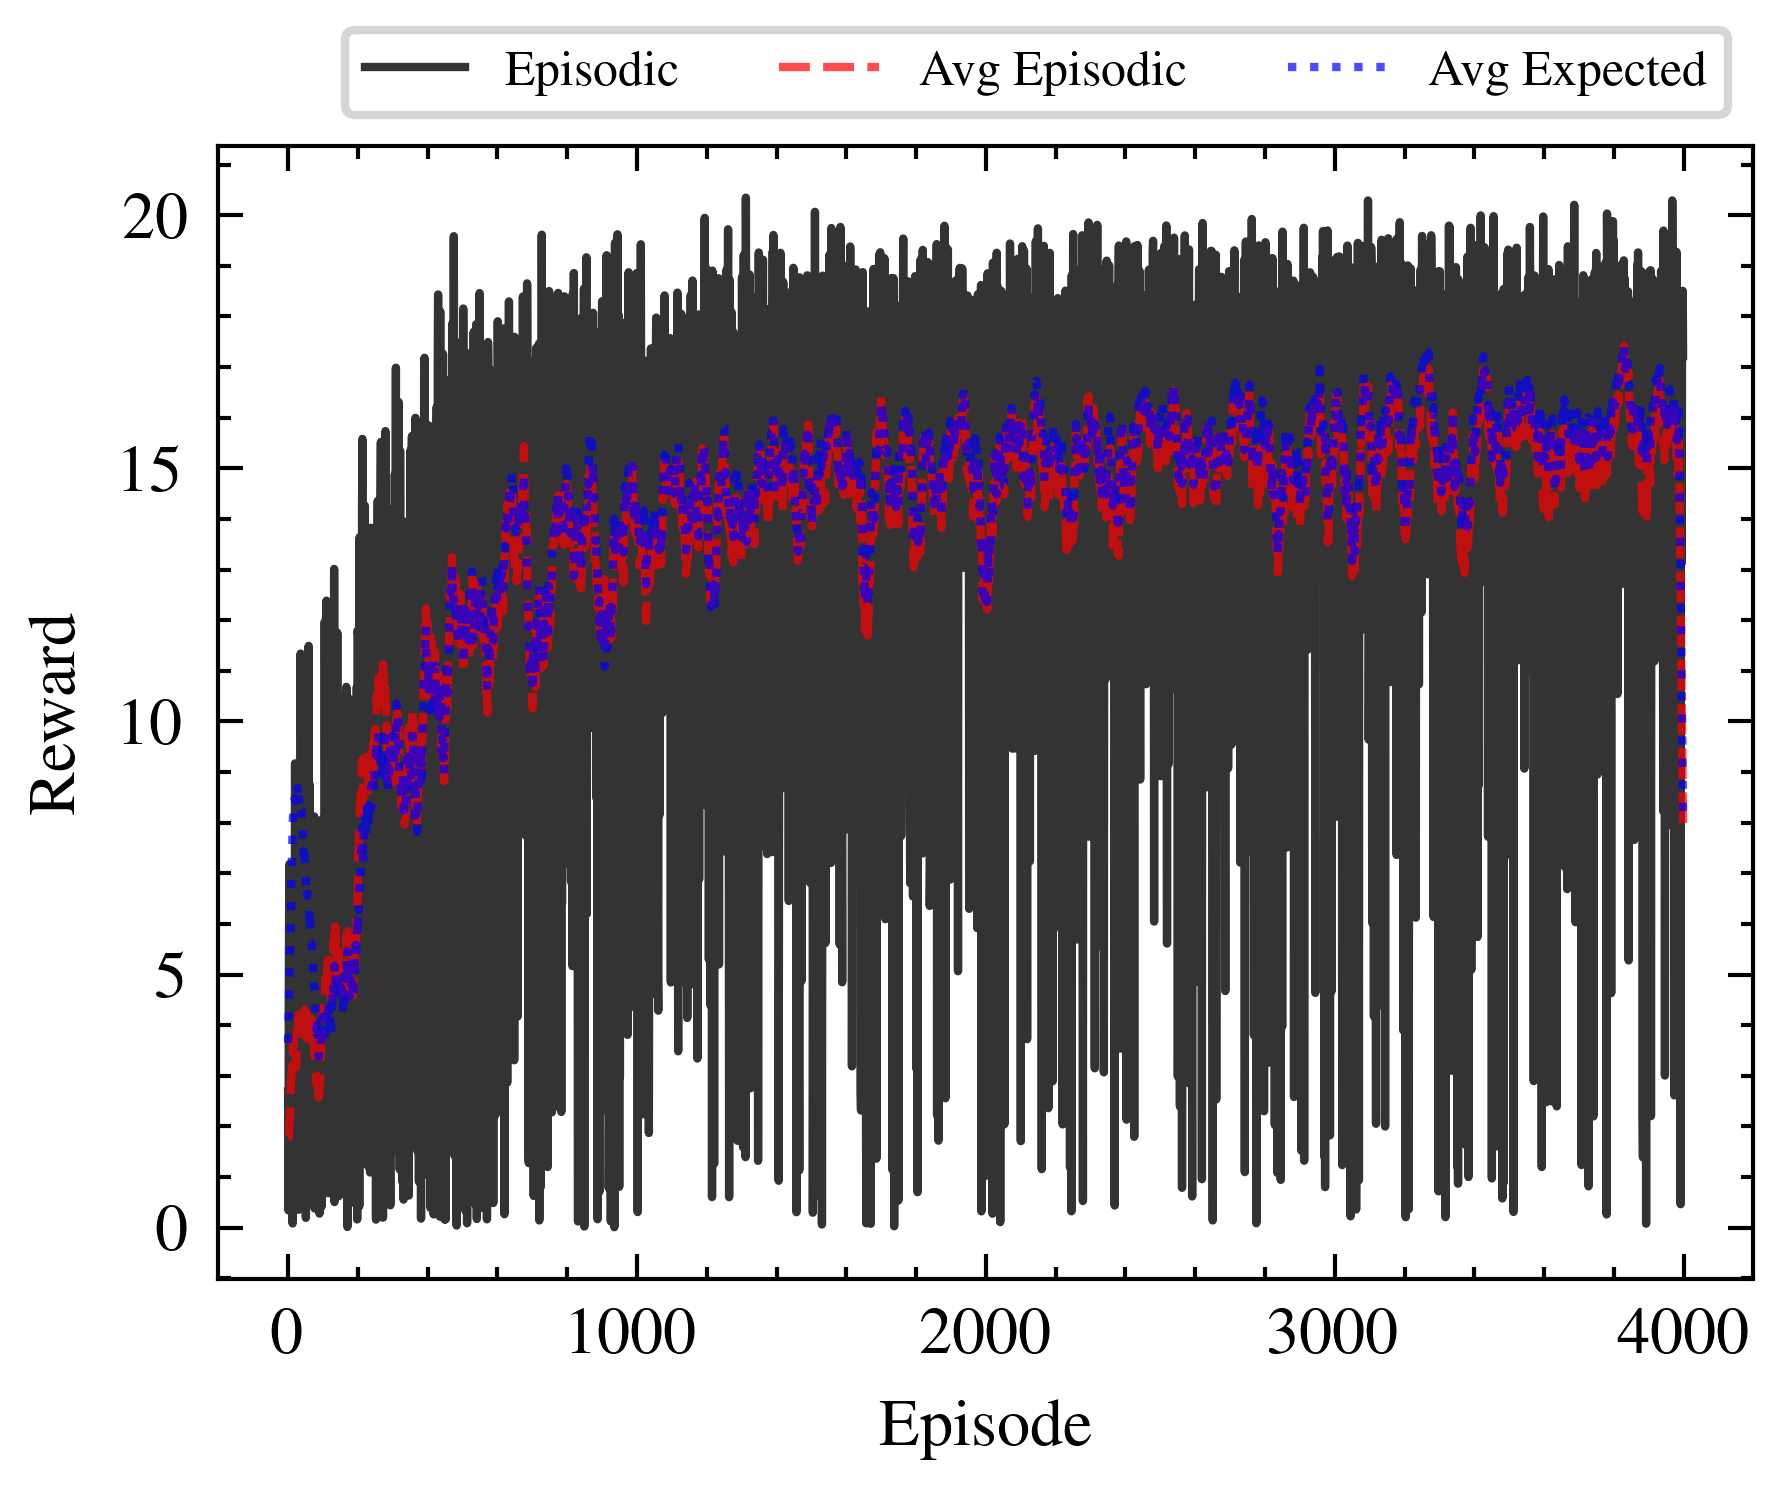

In [20]:

#plt.savefig('sensorbased_learning_curve_exp.pdf')
#plt.savefig('sensorbased_learning_curve_exp.jpeg')
fig, axs = plt.subplots(1,1)

LOGS = np.loadtxt('logs/logs_SIM.txt',delimiter=',')
avg_ret = np.convolve(LOGS[:,4], np.ones(25), 'same') / 25
exp_ret =  np.convolve(LOGS[:,6]*1.5*0.5, np.ones(25), 'same') / 25

axs.plot(LOGS[:,4], label="Episodic",alpha=0.8);
axs.plot(avg_ret, label="Avg Episodic",alpha=0.7);
axs.plot(exp_ret, label="Avg Expected",alpha=0.7);





axs.set_ylabel('Reward');
axs.legend(loc="upper right",bbox_to_anchor=(1,1.125), ncol =3, frameon = True,bbox_transform=axs.transAxes,prop={'size': 6})

#axs[0].legend(loc='lower center',frameon = True)

axs.set_xlabel('Episode')

fig.savefig('plots/Training_reward_simexp.pdf')
fig.savefig('plots/Training_reward_simexp.jpeg')

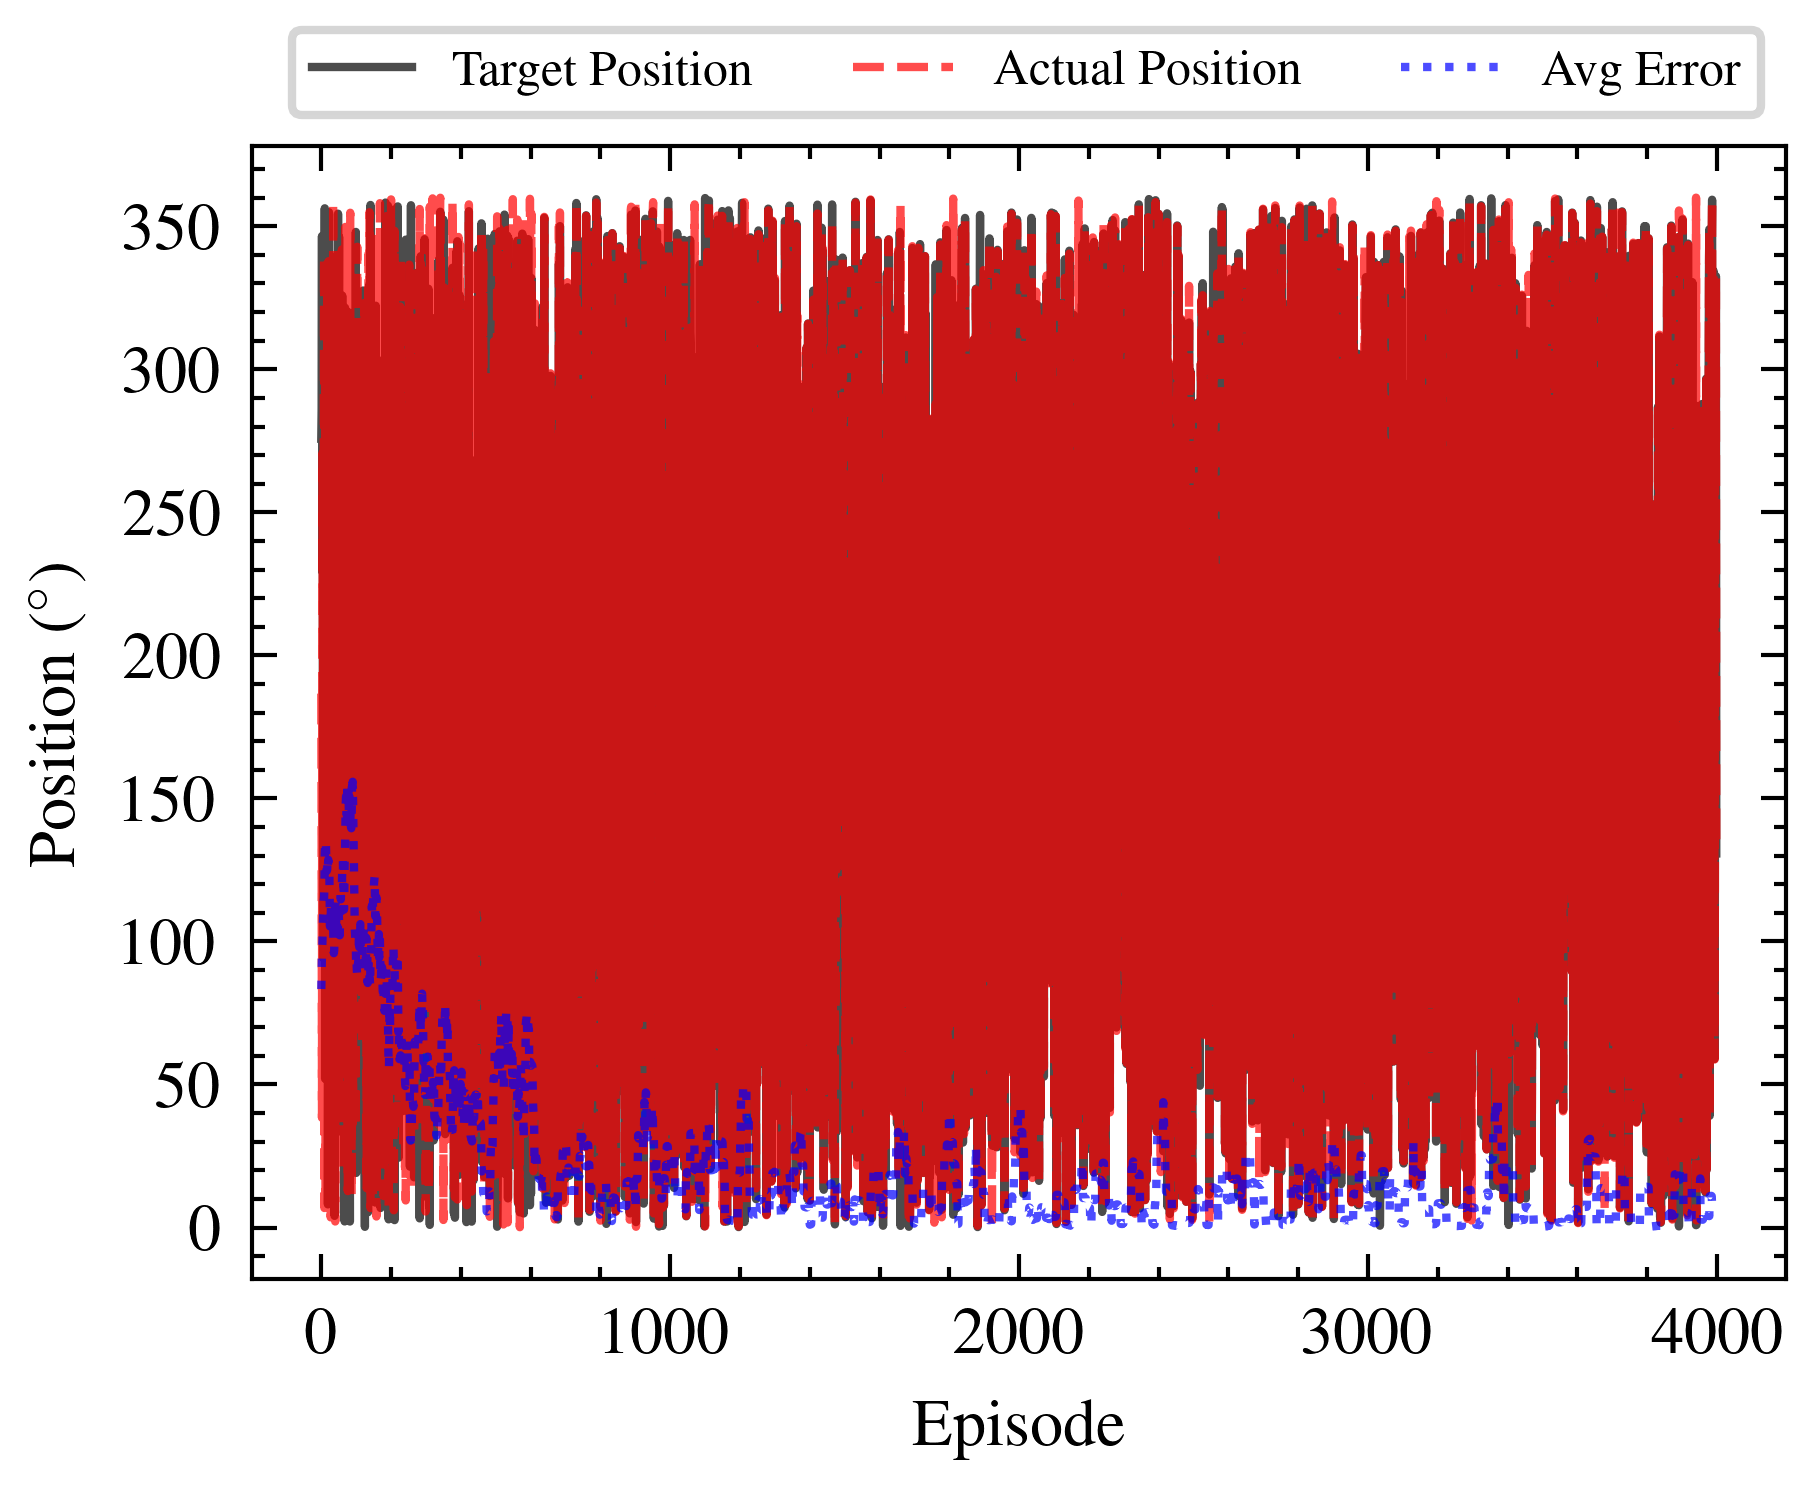

In [21]:

#plt.savefig('sensorbased_learning_curve_exp.pdf')
#plt.savefig('sensorbased_learning_curve_exp.jpeg')
fig, axs = plt.subplots(1,1)

LOGS = np.loadtxt('logs/logs_SIM_1.txt',delimiter=',')

Error_ret =  np.convolve(np.abs(LOGS[:,3]-LOGS[:,5]), np.ones(25), 'same') / 25



axs.plot(LOGS[:,3], label="Target Position",alpha=0.7);
axs.plot(LOGS[:,5], label="Actual Position",alpha=0.7);

axs.plot(Error_ret, label="Avg Error",alpha=0.7);


axs.set_ylabel('Position ($^\circ$)');
axs.legend(loc="upper right",bbox_to_anchor=(1,1.125), ncol =3, frameon = True,bbox_transform=axs.transAxes,prop={'size': 6})

#axs[0].legend(loc='lower center',frameon = True)

axs.set_xlabel('Episode')


fig.savefig('plots/Training_speed_simexp.pdf')
fig.savefig('plots/Training_speed_simexp.jpeg')

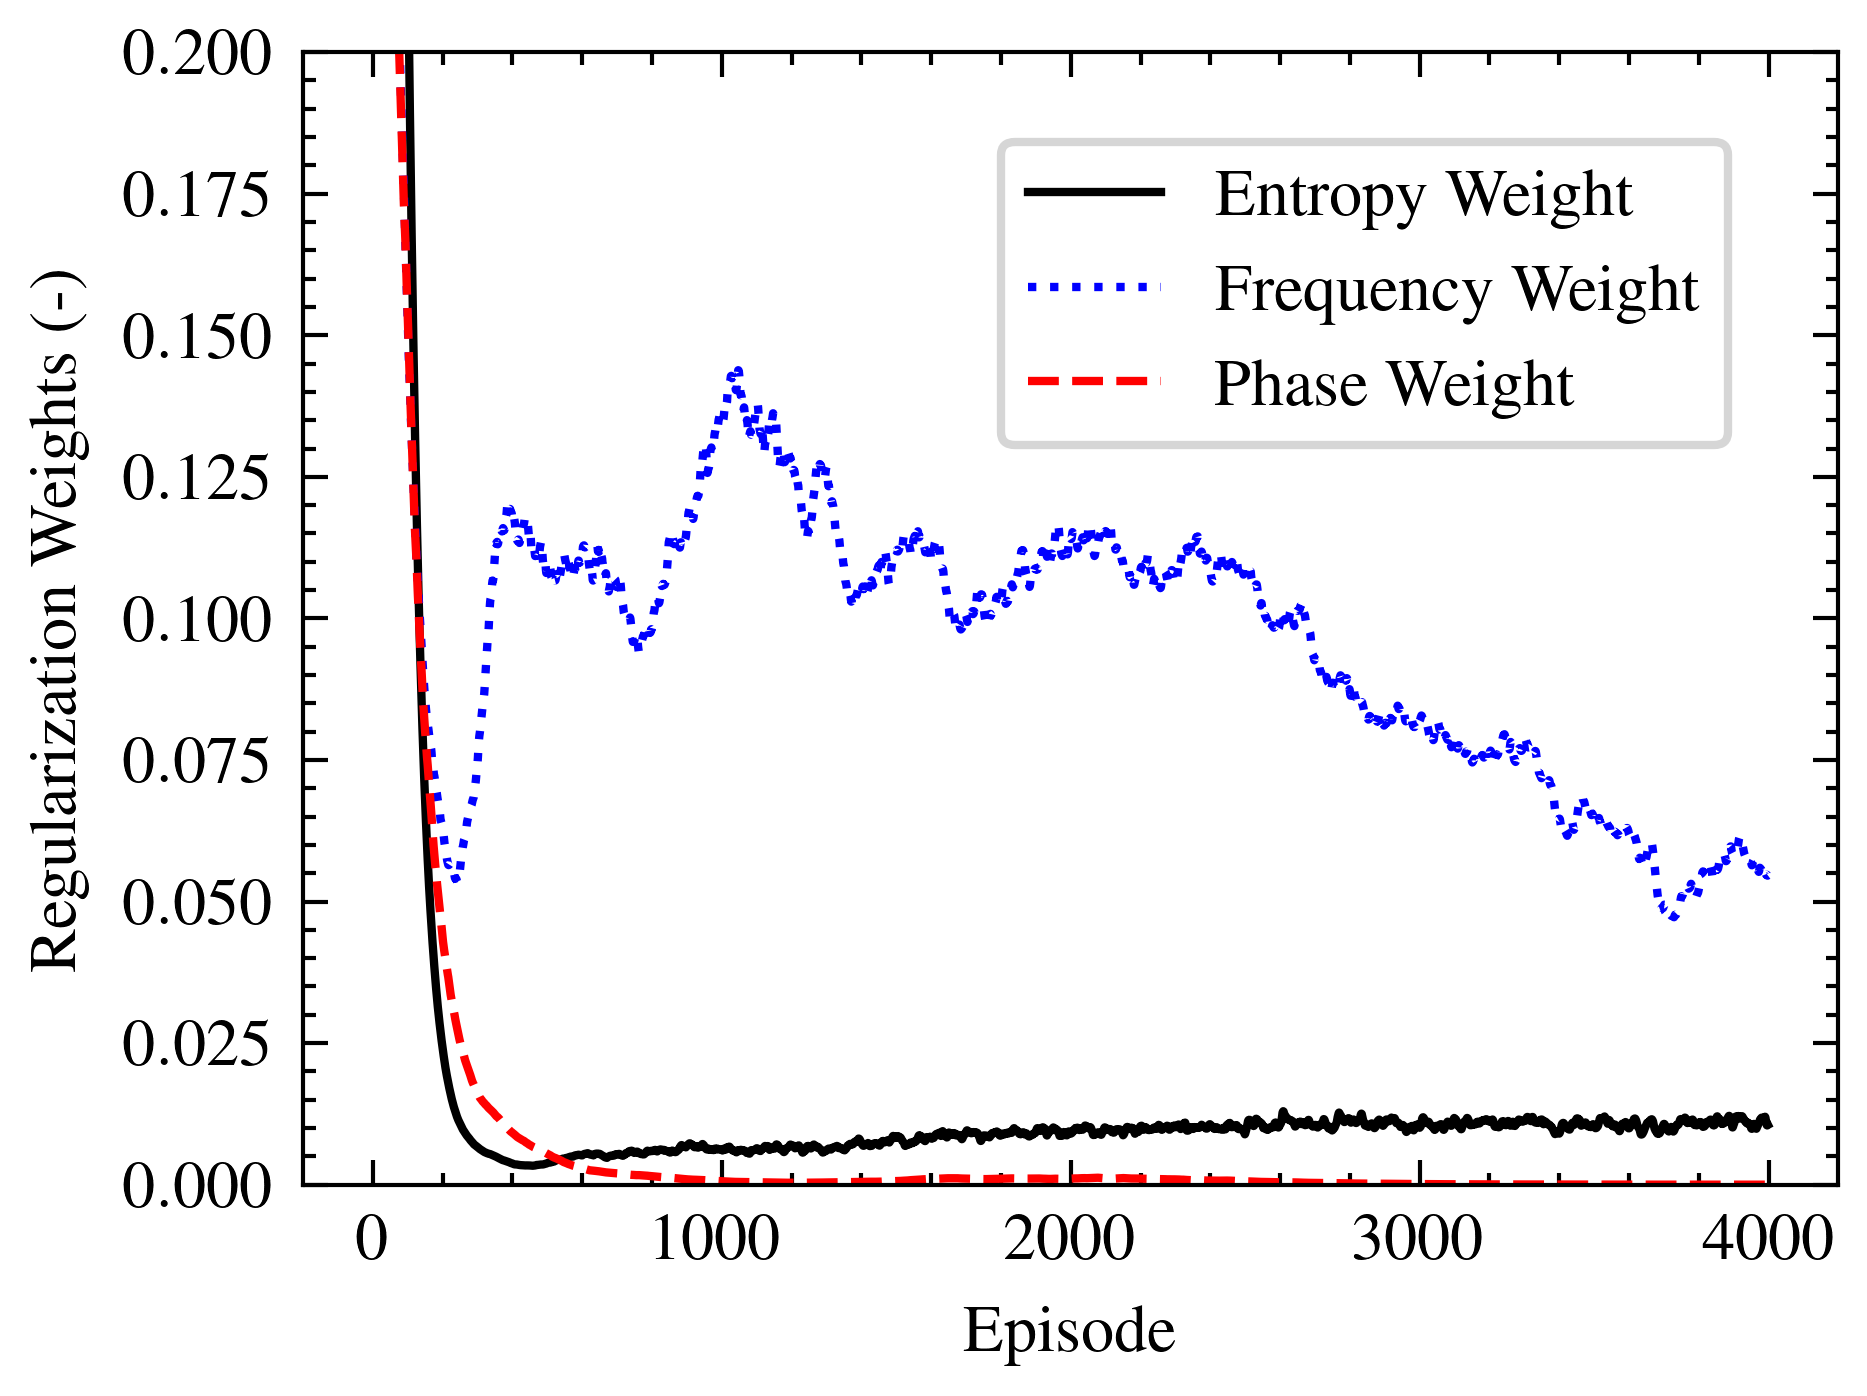

In [26]:

#plt.savefig('sensorbased_learning_curve_exp.pdf')
#plt.savefig('sensorbased_learning_curve_exp.jpeg')
fig, ax = plt.subplots(1,1)
LOGS = np.loadtxt('logs/logs_SIM.txt',delimiter=',')




ax.plot(LOGS[:,-3], label="Entropy Weight");
ax.plot(LOGS[:,-2],'b:',label="Frequency Weight");
ax.plot(LOGS[:,-1],label="Phase Weight");




ax.set_ylabel('Regularization Weights (-)');

fig.legend(loc="upper right",bbox_to_anchor=(0.95,0.95), ncol =1, frameon = True,bbox_transform=ax.transAxes,prop={'size': 8})

#axs[0].legend(loc='lower center',frameon = True)

ax.set_xlabel('Episode')
ax.set_ylim([0,0.2])

fig.savefig('plots/Training_weights_simexp.pdf')
fig.savefig('plots/Training_weights_simexp.jpeg')

In [33]:
agent.run_evals_ep('eval',n=100,freq=39,T=0,temp=30)

<Figure size 1980x1500 with 0 Axes>

(101, 73)


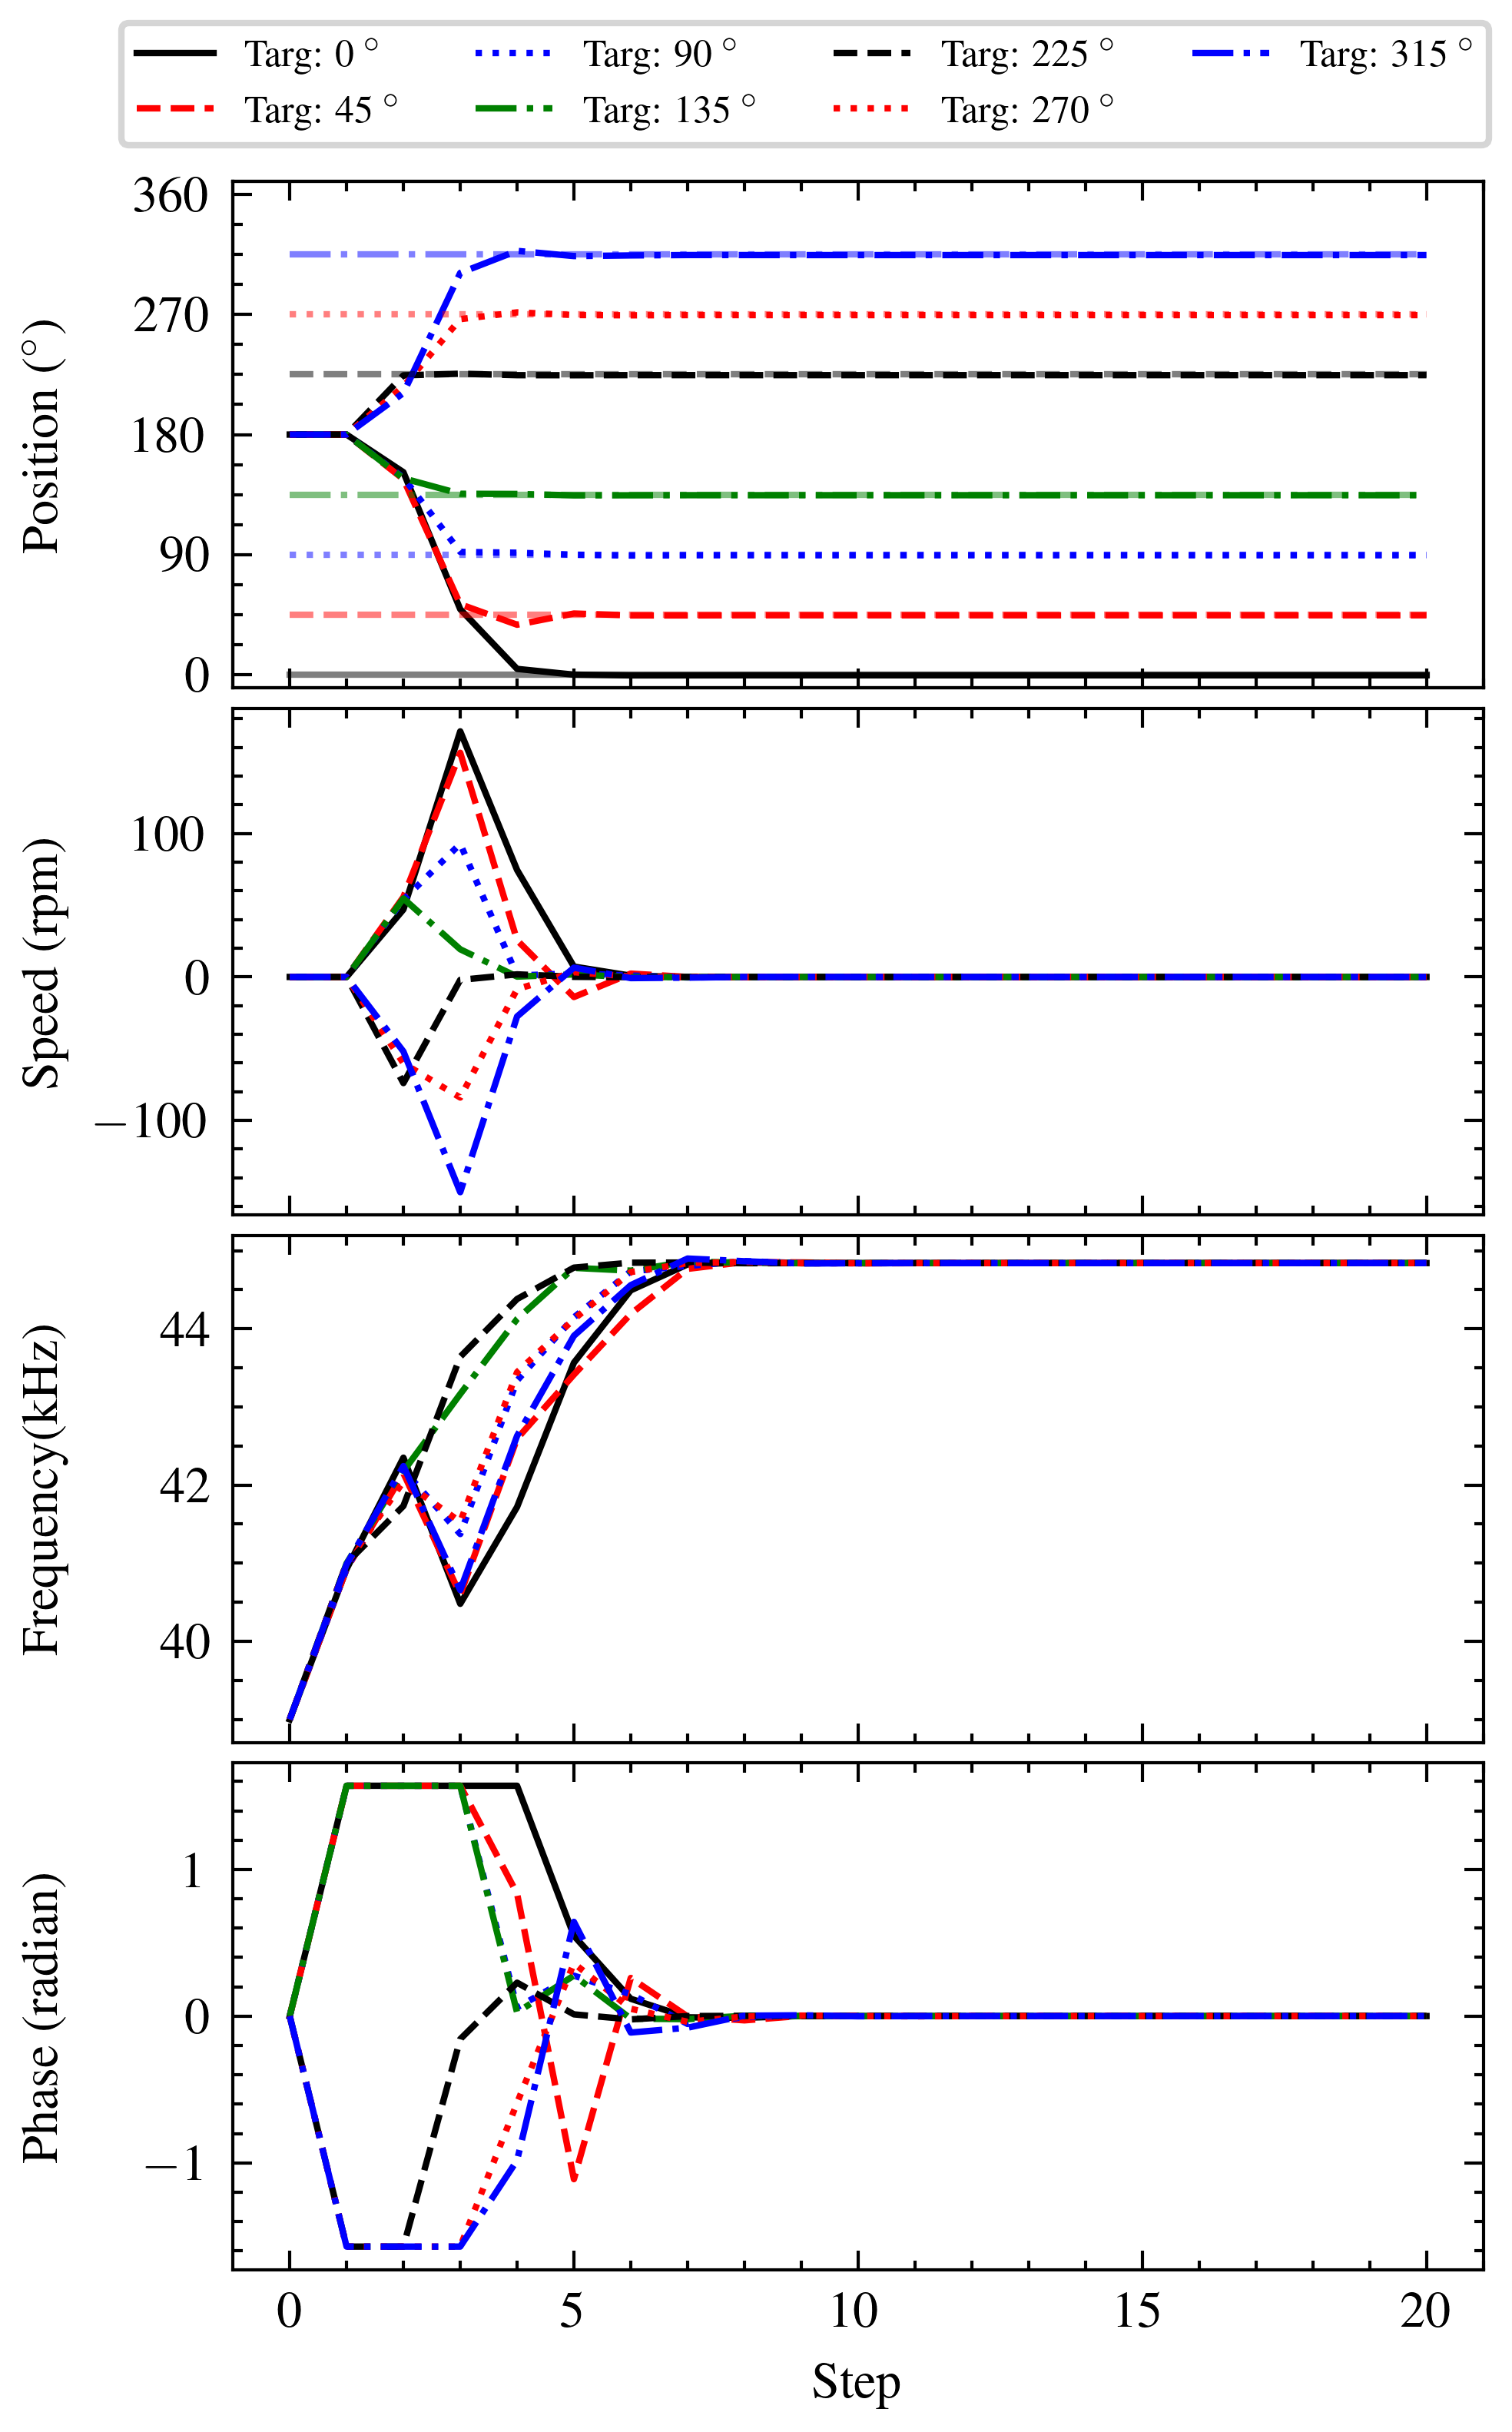

In [40]:
env = 'SIM'
fig, ax = plt.subplots(4,1,figsize=(3.5,6))
j = 0

data = np.loadtxt('logs/ep_eval_con_theta_SIM.txt'.format(env),delimiter=',')
print(data.shape)
#      return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])
poses = [0, 45, 90, 135, 225, 270, 315]
lineType = ['-','--',':','-.','--',':','-.','-']


ax1 = ax[0].twinx()
for i in range(7):
    ind = 6 + i*9
    ax[0].plot(data[:21,0], ((data[:21,ind] - data[:21,ind+1])+360), lineType[i], label="Targ: {} $^\circ$".format(poses[i]))
    ax[1].plot(data[:21,0], data[:21,ind-2], lineType[i])
    ax[2].plot(data[:21,0], data[:21,ind-5], lineType[i])
    ax[3].plot(data[:21,0], data[:21,ind-1], lineType[i])
    ax1.plot([0,20],[poses[i],poses[i]], lineType[i], alpha=0.5)

ax[0].legend()

ax[3].set_xlabel('Step')
ax[0].set_ylabel('Position ($^\circ$)')
ax[1].set_ylabel('Speed (rpm)')
ax[2].set_ylabel('Frequency(kHz)')
ax[3].set_ylabel('Phase (radian)')
ax1.set_yticks([])

ax[0].legend(loc="upper right",bbox_to_anchor=(1.02,1.35),frameon = True, ncol=4,prop={'size': 6})
 
for ax0 in ax.flat:
    ax0.label_outer()
plt.subplots_adjust(wspace=0.0, hspace=0.04)
ax[0].set_yticks([0,90,180,270,360])
ax[0].set_ylim(-10,370)
ax1.set_ylim(-10,370)

#ax.legend()

'''
plt.figure()
plt.plot(Ep_ret,label="Episode Reward");
plt.plot(avg_ret, label="Average Reward");
plt.plot(LOGS[:,-1], label="Expected Reward");
plt.xlabel('Episode');
plt.ylabel('Reward');
plt.legend()
'''
fig.align_ylabels()


fig.savefig('plots/conTheta.pdf')
fig.savefig('plots/conTheta.jpeg')


(101, 73)


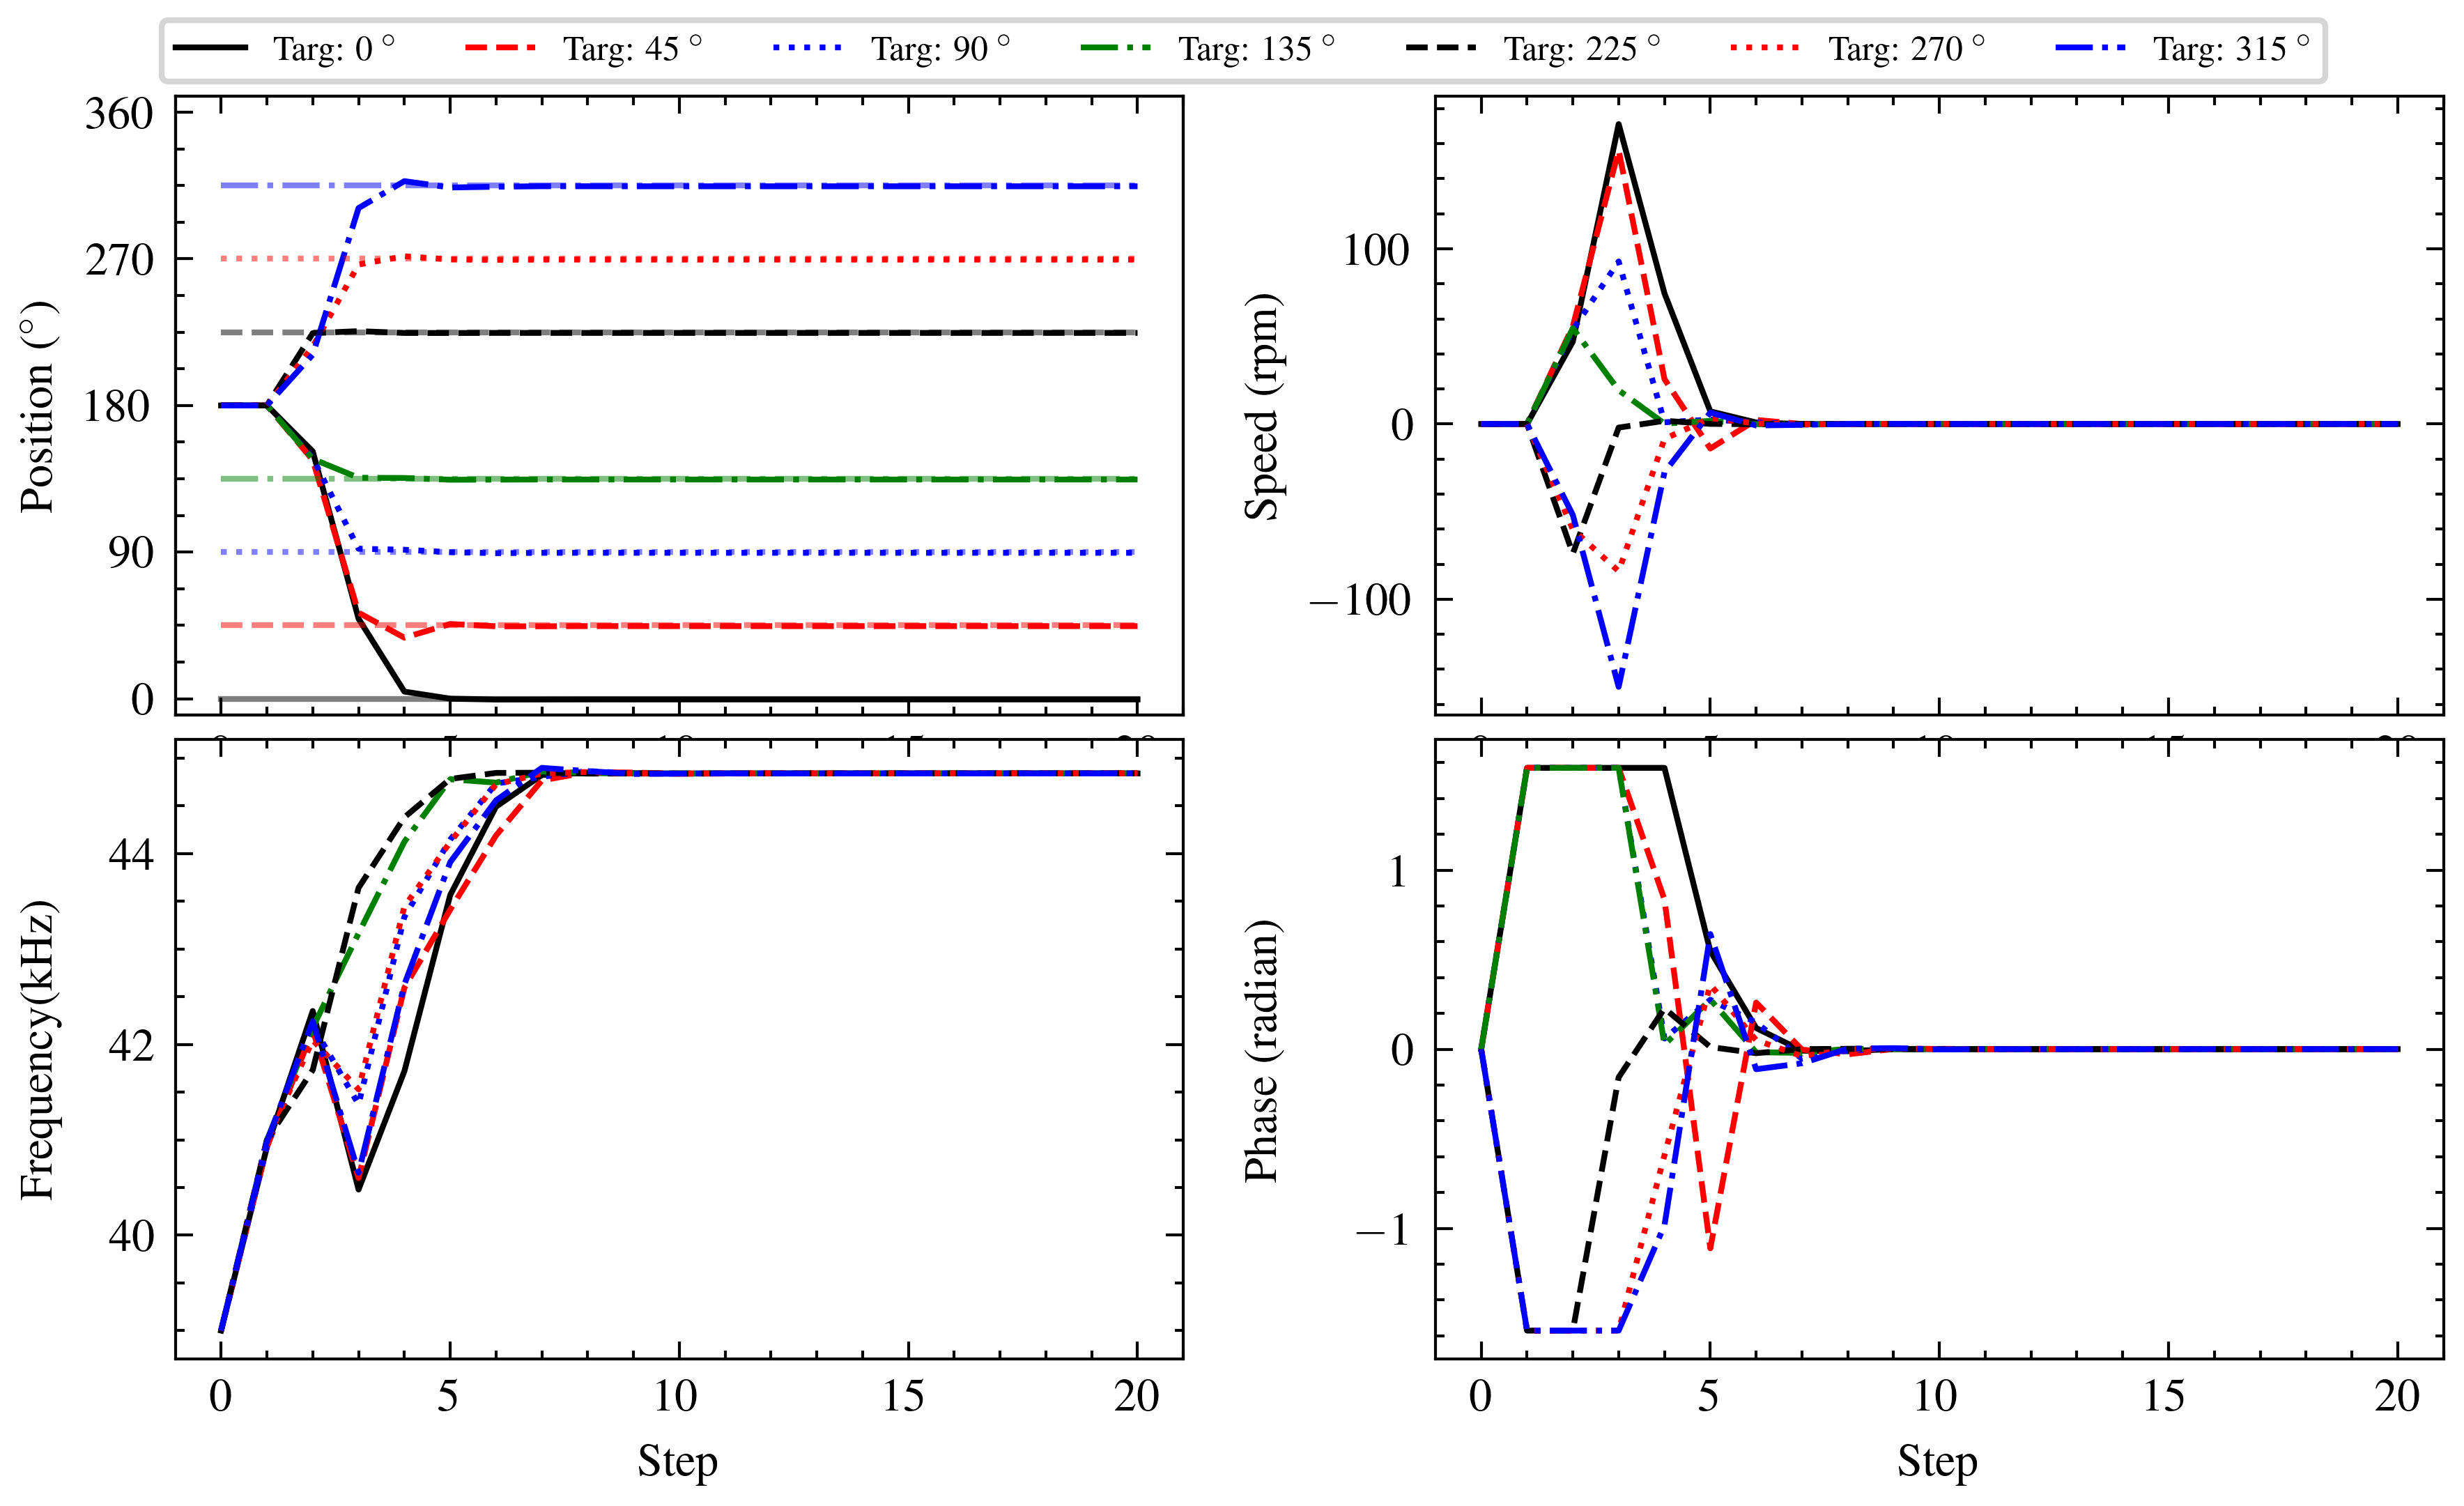

In [21]:
env = 'SIM'
fig, ax = plt.subplots(2,2,figsize=(7,4))
j = 0

data = np.loadtxt('logs/ep_eval_con_theta_SIM.txt'.format(env),delimiter=',')
print(data.shape)
#      return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])
poses = [0, 45, 90, 135, 225, 270, 315]
lineType = ['-','--',':','-.','--',':','-.','-']


ax1 = ax[0,0].twinx()
for i in range(7):
    ind = 6 + i*9
    ax[0,0].plot(data[:21,0], ((data[:21,ind] - data[:21,ind+1])+360), lineType[i], label="Targ: {} $^\circ$".format(poses[i]))
    ax[0,1].plot(data[:21,0], data[:21,ind-2], lineType[i])
    ax[1,0].plot(data[:21,0], data[:21,ind-5], lineType[i])
    ax[1,1].plot(data[:21,0], data[:21,ind-1], lineType[i])
    ax1.plot([0,20],[poses[i],poses[i]], lineType[i], alpha=0.5)


ax[1,1].set_xlabel('Step')
ax[1,0].set_xlabel('Step')

ax[0,0].set_ylabel('Position ($^\circ$)')
ax[0,1].set_ylabel('Speed (rpm)')
ax[1,0].set_ylabel('Frequency(kHz)')
ax[1,1].set_ylabel('Phase (radian)')
ax1.set_yticks([])

ax[0,0].legend(loc="upper right",bbox_to_anchor=(2.15,1.15),frameon = True, ncol=7,prop={'size': 6})
 

plt.subplots_adjust(wspace=0.25, hspace=0.04)
ax[0,0].set_yticks([0,90,180,270,360])
ax[0,0].set_ylim(-10,370)
ax1.set_ylim(-10,370)

#ax.legend()

'''
plt.figure()
plt.plot(Ep_ret,label="Episode Reward");
plt.plot(avg_ret, label="Average Reward");
plt.plot(LOGS[:,-1], label="Expected Reward");
plt.xlabel('Episode');
plt.ylabel('Reward');
plt.legend()
'''
fig.align_labels()


fig.savefig('plots/conTheta.pdf')
fig.savefig('plots/conTheta.jpeg')


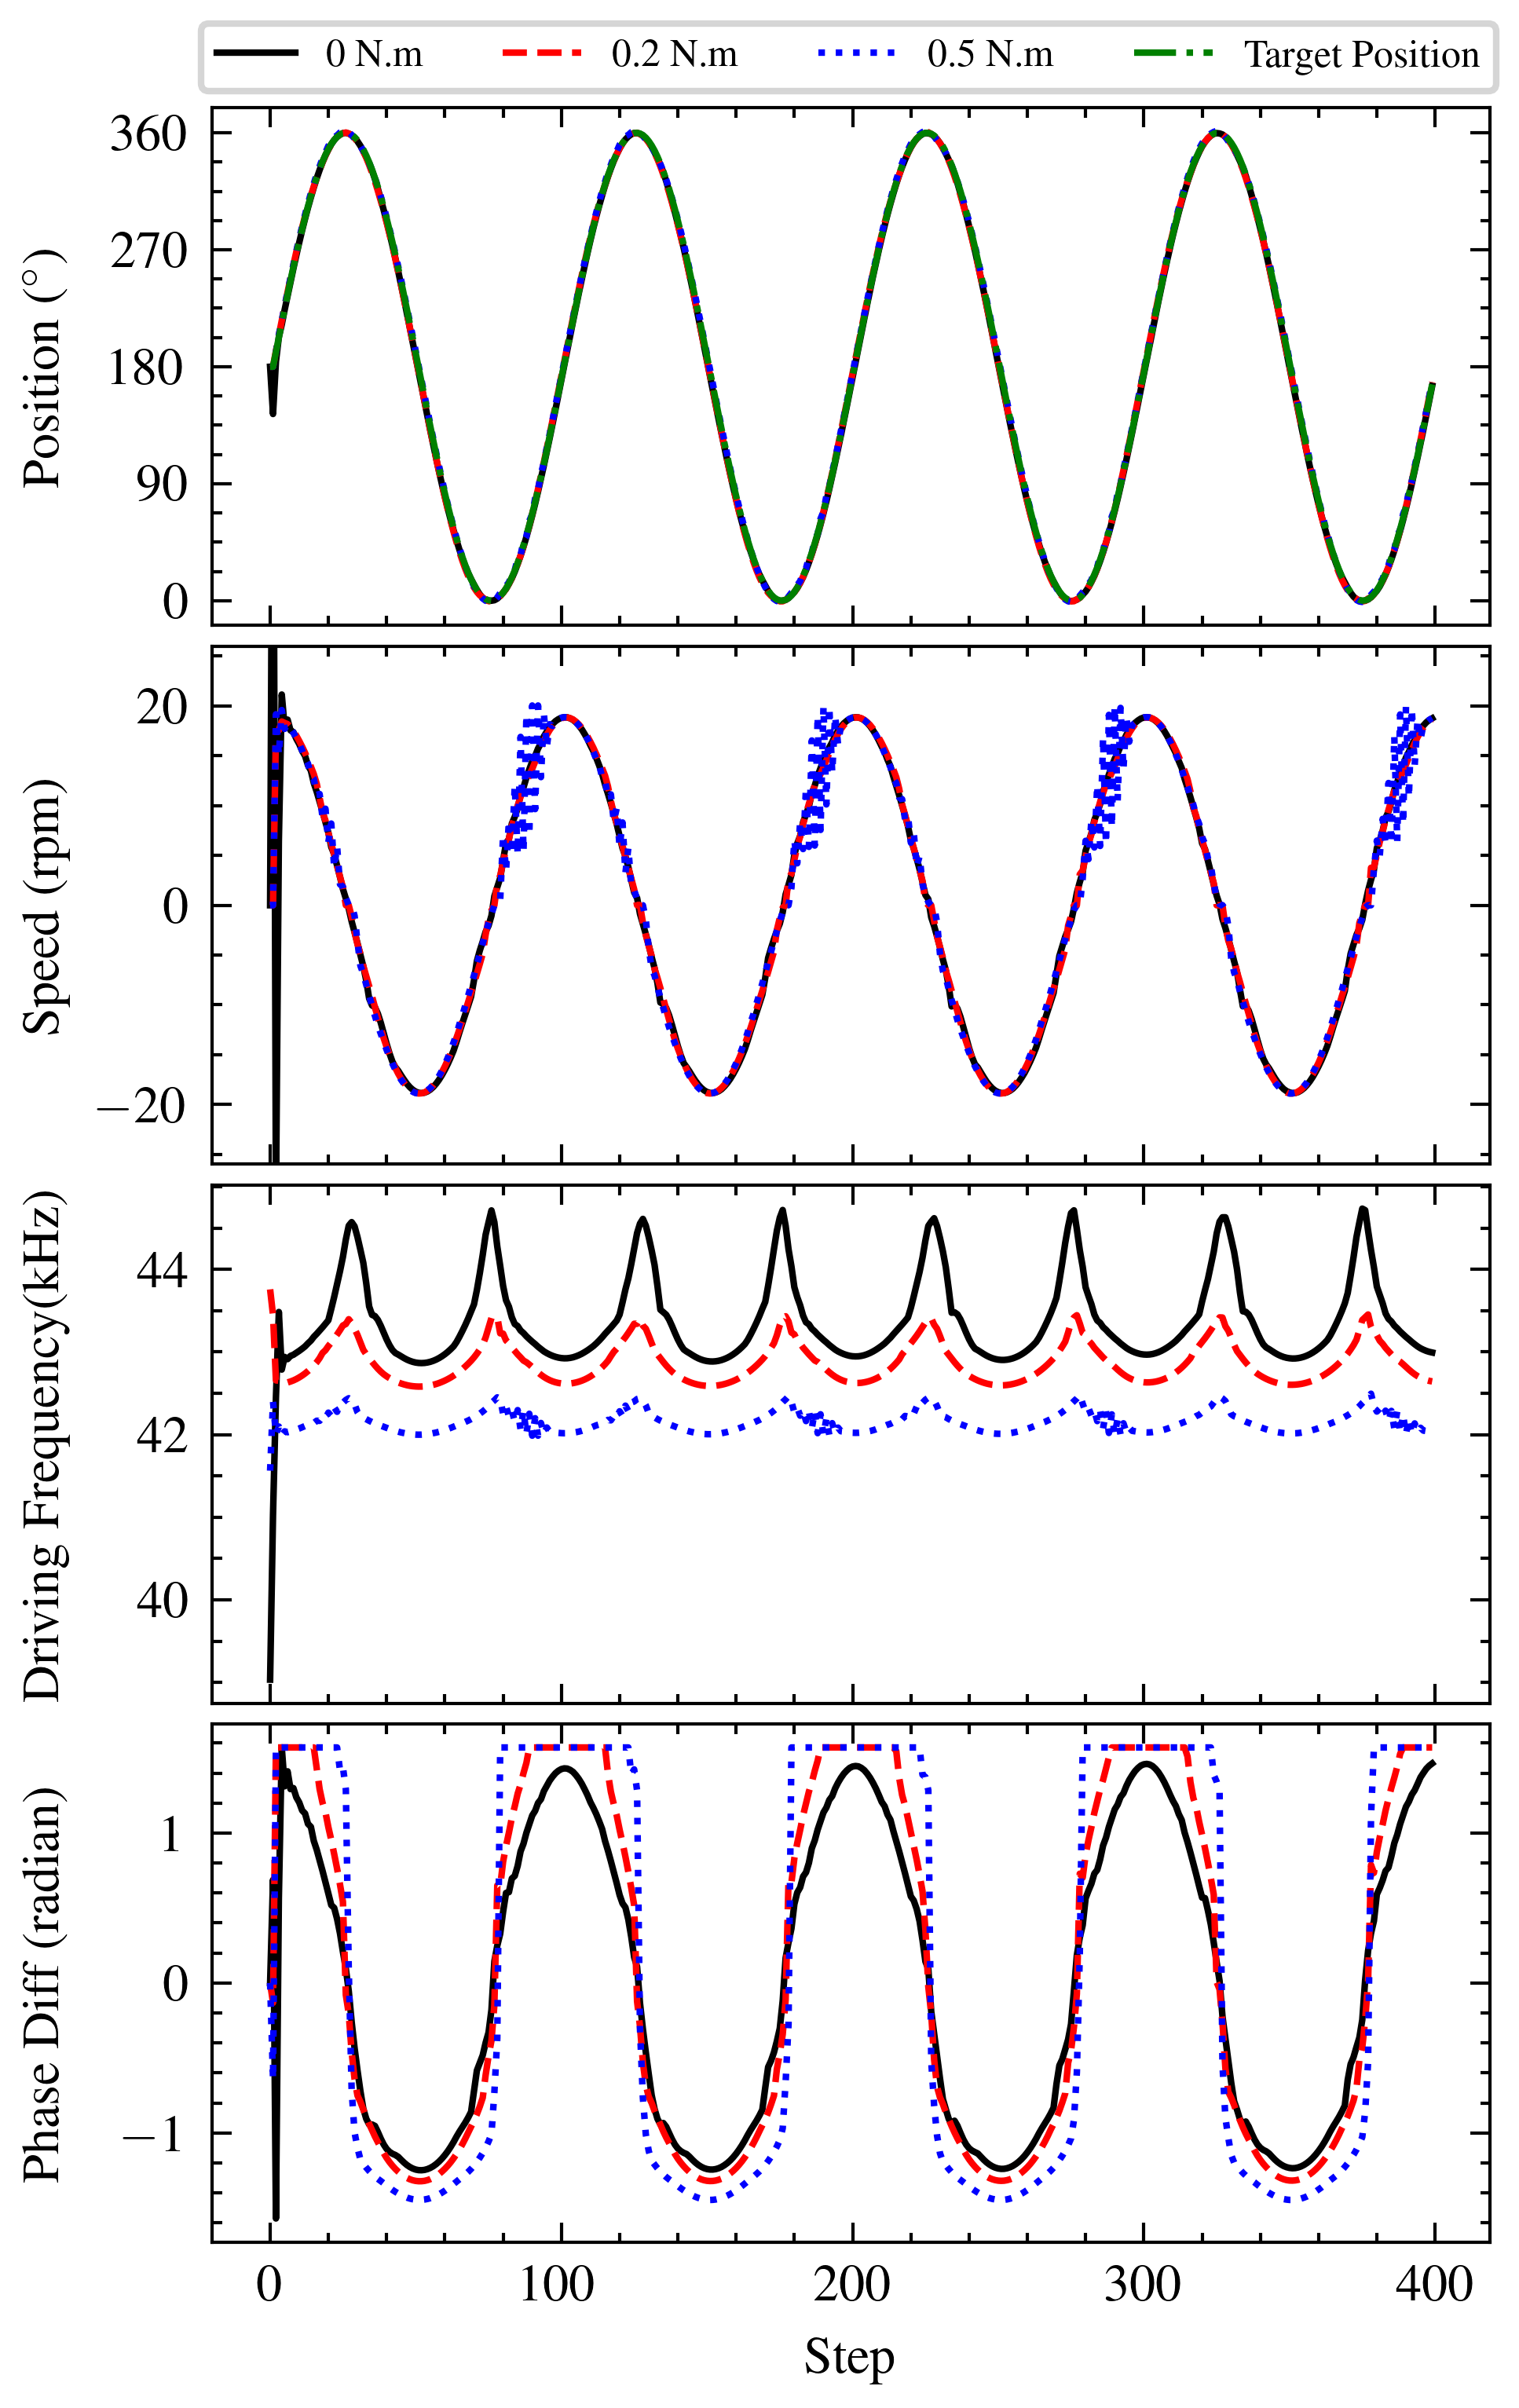

In [12]:
env = 'SIM'
fig, ax = plt.subplots(4,1,figsize=(3.5,6))
j = 0
n= 400
for T in [0,0.2,0.5]:
    data = np.loadtxt('logs/sinTheta_conTorque_{}Nm_SIM.txt'.format(T),delimiter=',')
    #      return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])
    theta = ((data[:n,5] + data[:n,6]))
    ax[0].plot( theta, label='{} N.m'.format(T))
    ax[1].plot(data[:n,3])
    ax[2].plot(data[:n,0])
    ax[3].plot(data[:n,4])

ax[0].plot(data[:n,6] ,label='Target Position')

ax[3].set_xlabel('Step')
ax[0].set_ylabel('Position ($^\circ$)')
ax[1].set_ylabel('Speed (rpm)')
ax[2].set_ylabel('Driving Frequency(kHz)')
ax[3].set_ylabel('Phase Diff (radian)')


ax[0].legend(loc="upper right",bbox_to_anchor=(1.02,1.2),frameon = True, ncol=,prop={'size': 6})
 
for ax0 in ax.flat:
    ax0.label_outer()
plt.subplots_adjust(wspace=0.0, hspace=0.04)
fig.align_ylabels()
#ax.set_ylim(140,160)]
ax[0].set_yticks([0,90,180,270,360])
ax[1].set_ylim([-26,26])
#ax.legend()

'''
plt.figure()
plt.plot(Ep_ret,label="Episode Reward");
plt.plot(avg_ret, label="Average Reward");
plt.plot(LOGS[:,-1], label="Expected Reward");
plt.xlabel('Episode');
plt.ylabel('Reward');
plt.legend()
'''


fig.savefig('plots/sinTheta.pdf')
fig.savefig('plots/sinTheta.jpeg')


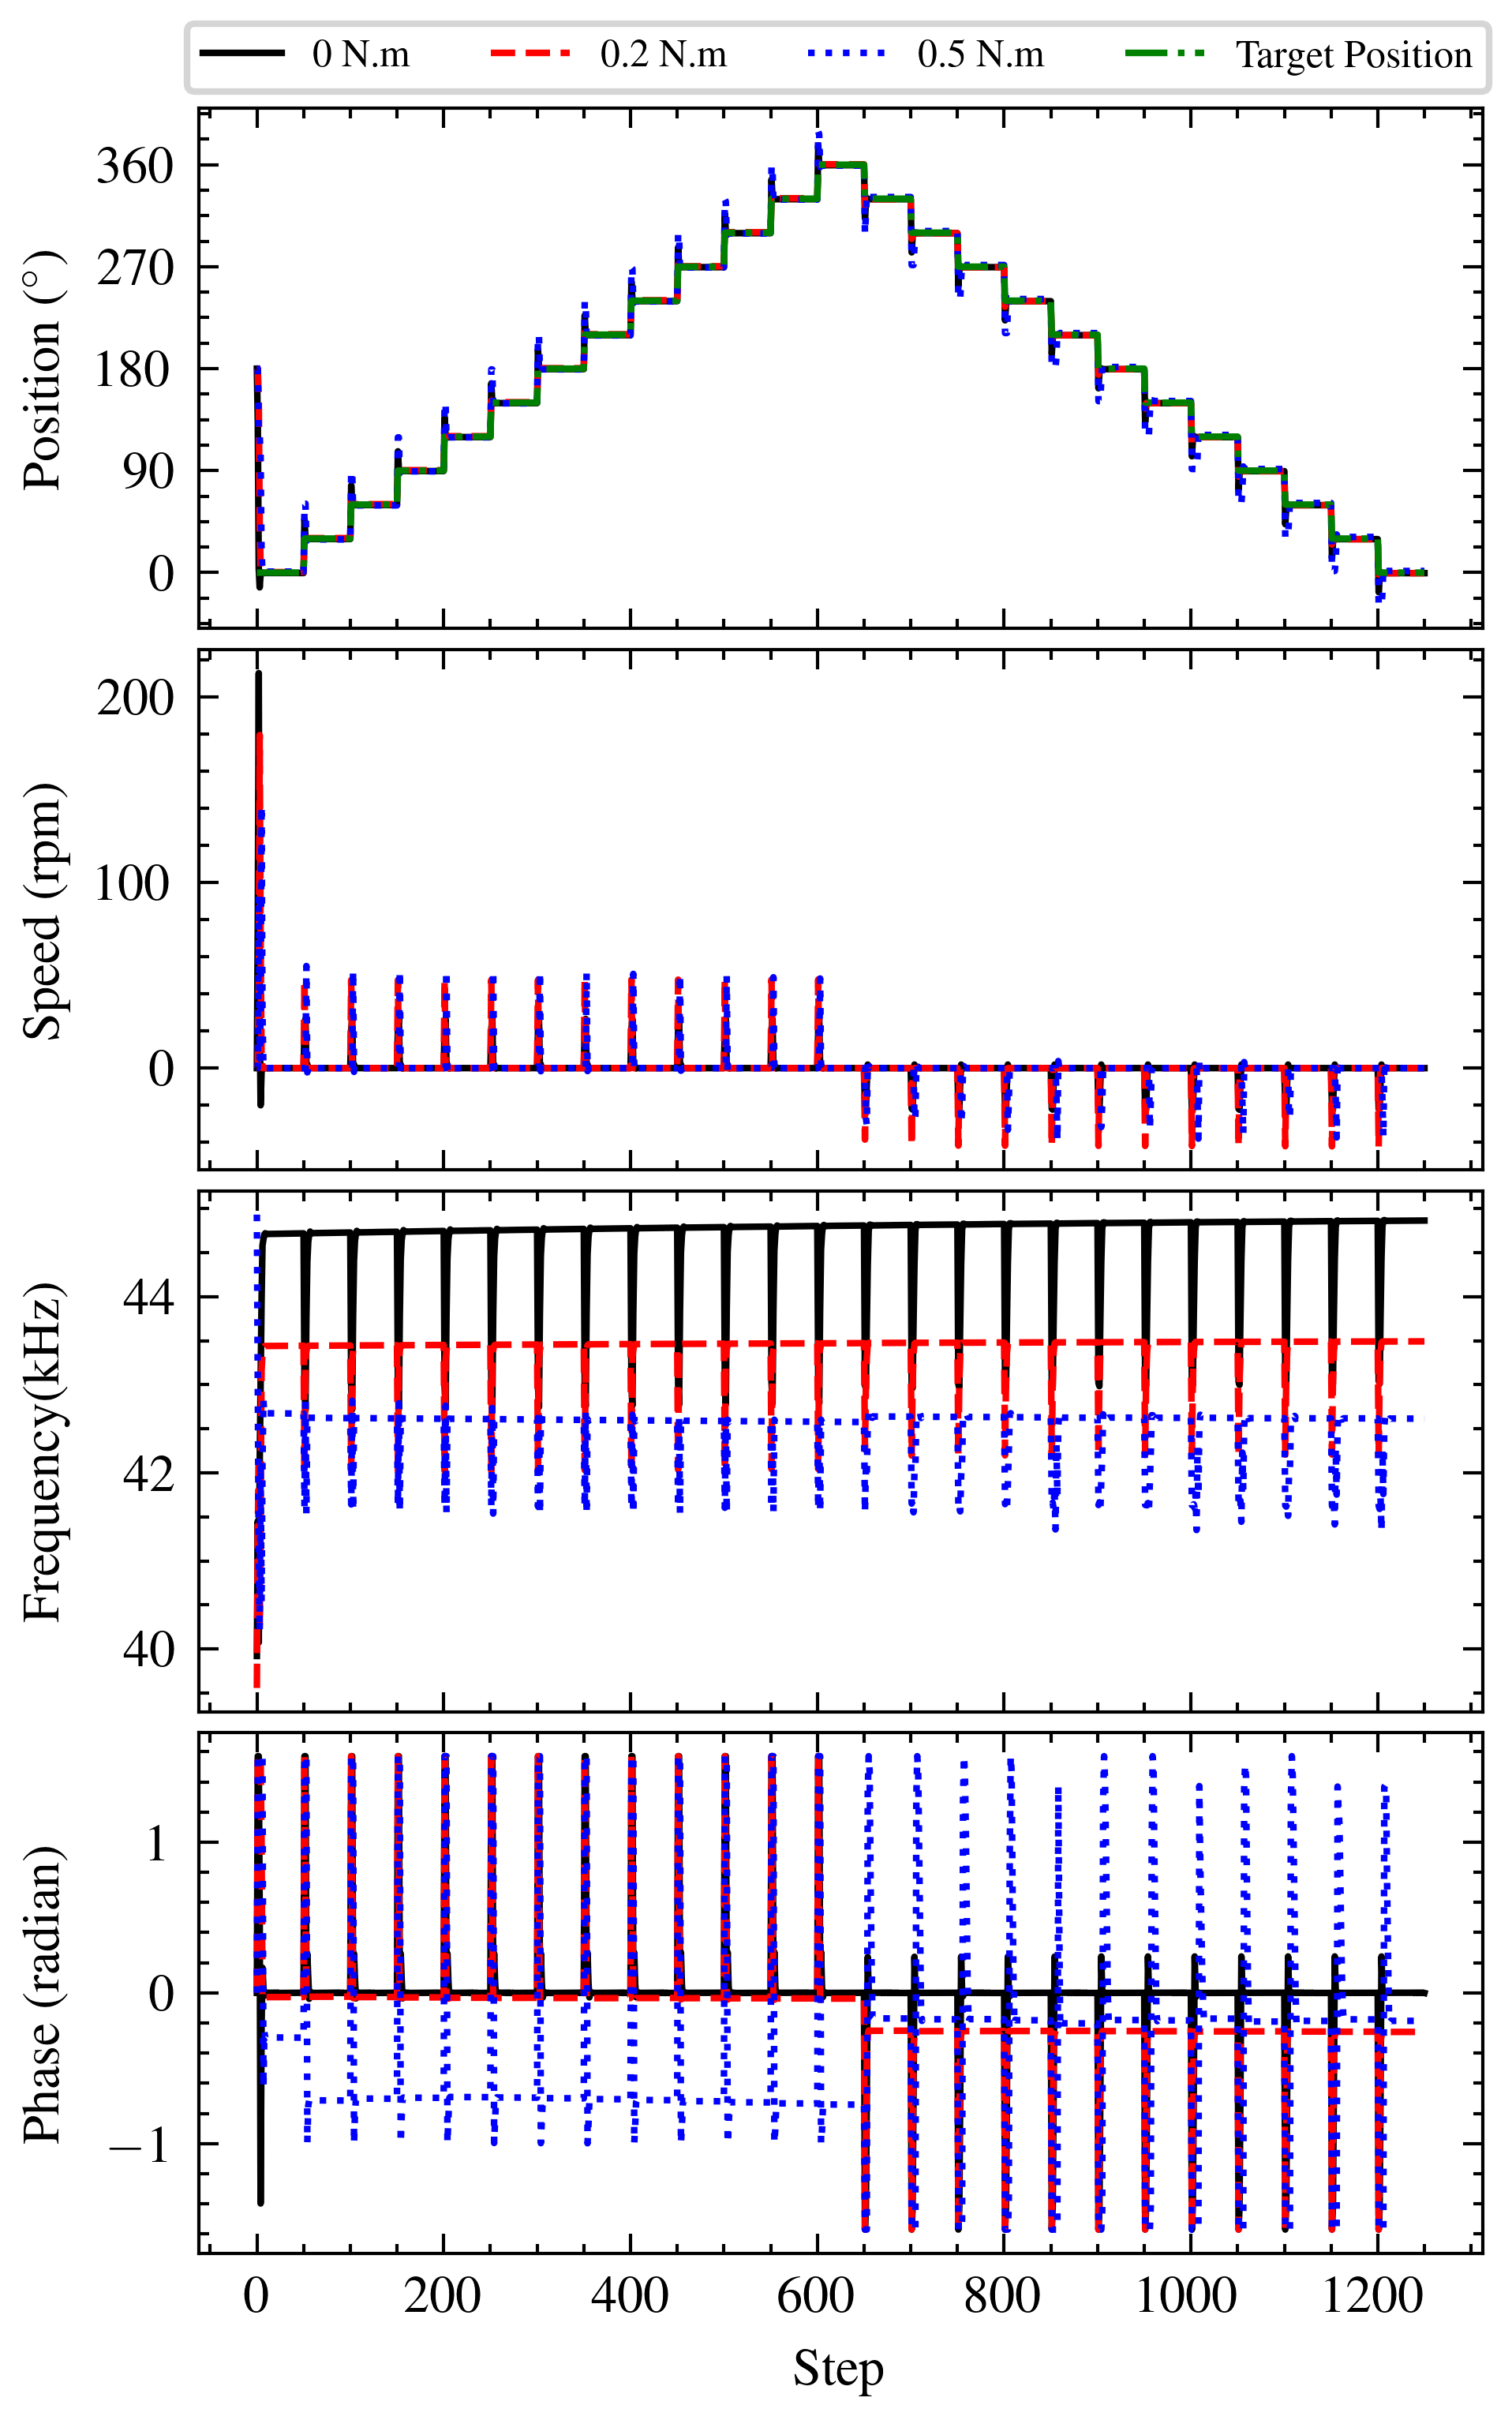

In [42]:
env = 'SIM'
fig, ax = plt.subplots(4,1,figsize=(3.5,6))
j = 0
for T in [0,0.2,0.5]:
    data = np.loadtxt('logs/stepTheta_conTorque_{}Nm_SIM.txt'.format(T),delimiter=',')
    #      return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])
    ax[0].plot(((data[:,5] + data[:,6])) , label='{} N.m'.format(T))
    ax[1].plot(data[:,3])
    ax[2].plot(data[:,0])
    ax[3].plot(data[:,4])

ax[0].plot((data[:,6]) ,label='Target Position')

ax[3].set_xlabel('Step')
ax[0].set_ylabel('Position ($^\circ$)')
ax[1].set_ylabel('Speed (rpm)')
ax[2].set_ylabel('Frequency(kHz)')
ax[3].set_ylabel('Phase (radian)')


ax[0].legend(loc="upper right",bbox_to_anchor=(1.02,1.2),frameon = True, ncol=4,prop={'size': 6})
 
for ax0 in ax.flat:
    ax0.label_outer()
plt.subplots_adjust(wspace=0.0, hspace=0.04)
#ax.set_ylim(140,160)
#ax.legend()
fig.align_ylabels()

ax[0].set_yticks([0,90,180,270,360])

'''
plt.figure()
plt.plot(Ep_ret,label="Episode Reward");
plt.plot(avg_ret, label="Average Reward");
plt.plot(LOGS[:,-1], label="Expected Reward");
plt.xlabel('Episode');
plt.ylabel('Reward');
plt.legend()
'''


fig.savefig('plots/stepTheta.pdf')
fig.savefig('plots/stepTheta.jpeg')


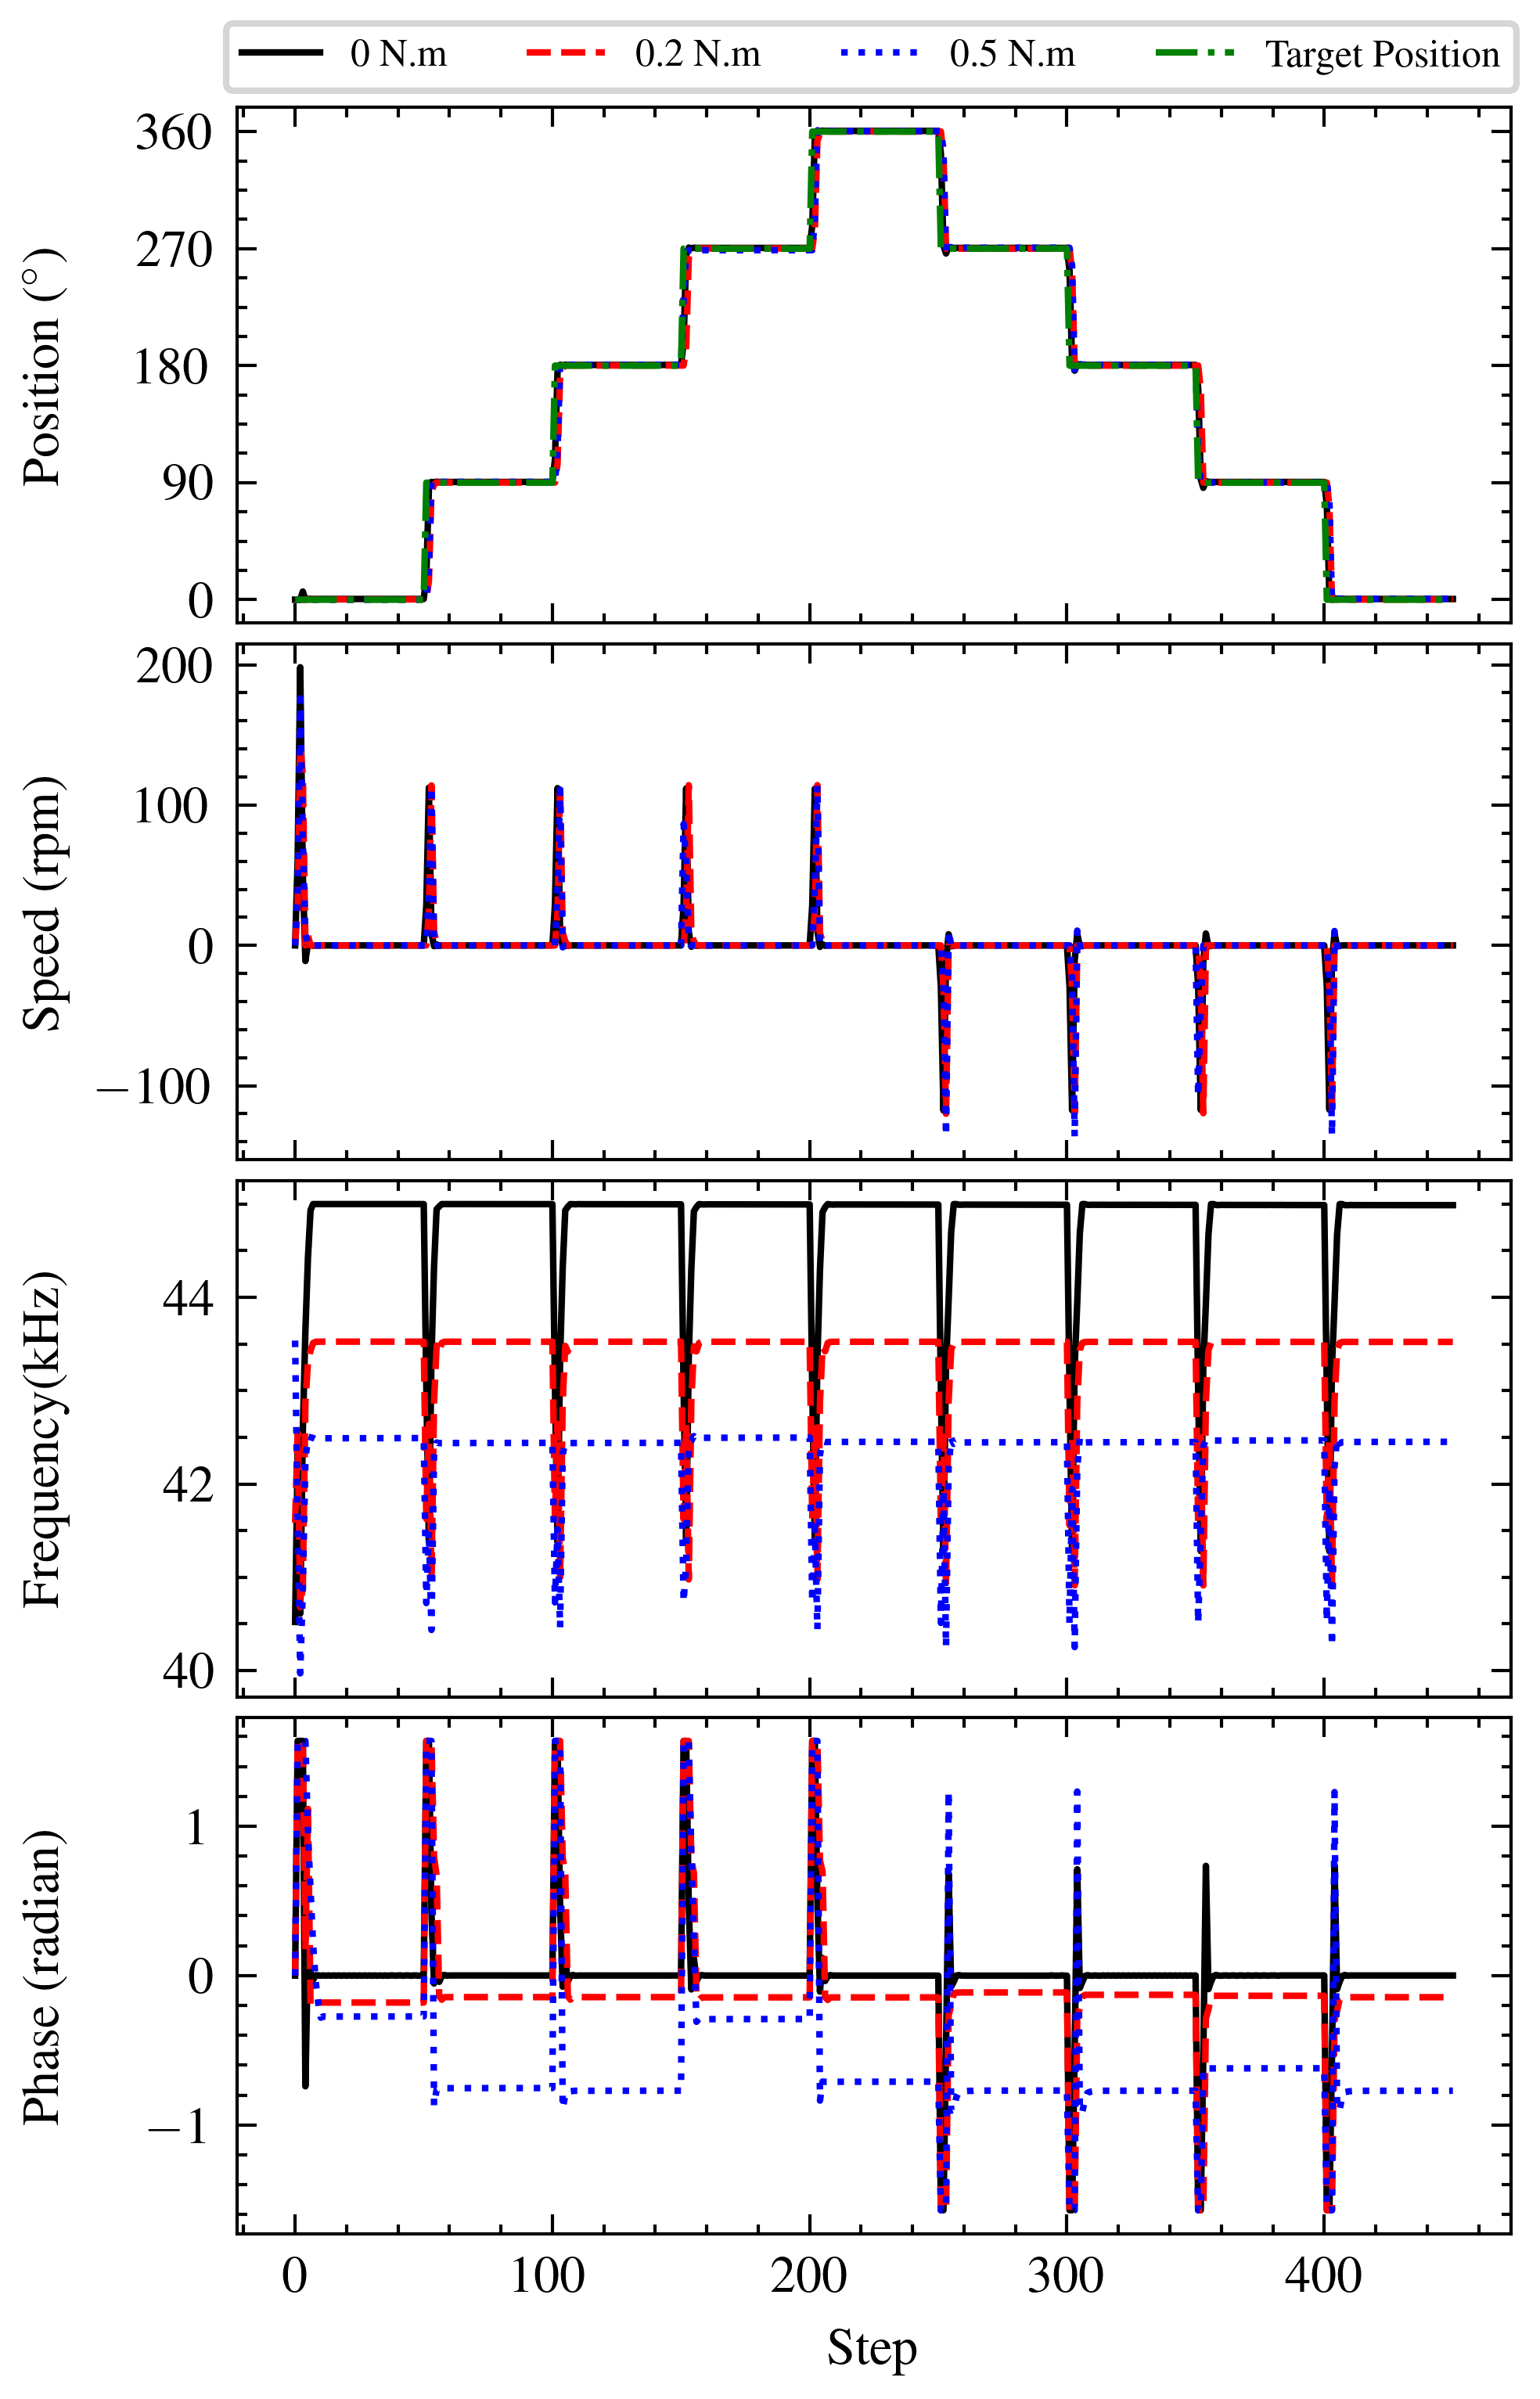

In [49]:
env = 'SIM'
fig, ax = plt.subplots(4,1,figsize=(3.5,6))
j = 0
for T in [0,0.2,0.5]:
    data = np.loadtxt('logs/stepTheta_conTorque5_{}Nm_SIM.txt'.format(T),delimiter=',')
    #      return np.array([self.freq, self.temp, self.T, self.speed,self.phase,self.err,self.targetTheta])
    ax[0].plot((np.maximum(0,(-data[:,5] + data[:,6]))) , label='{} N.m'.format(T))
    ax[1].plot(data[:,3])
    ax[2].plot(data[:,0])
    ax[3].plot(data[:,4])

ax[0].plot((data[:,6]) ,label='Target Position')

ax[3].set_xlabel('Step')
ax[0].set_ylabel('Position ($^\circ$)')
ax[1].set_ylabel('Speed (rpm)')
ax[2].set_ylabel('Frequency(kHz)')
ax[3].set_ylabel('Phase (radian)')


ax[0].legend(loc="upper right",bbox_to_anchor=(1.02,1.2),frameon = True, ncol=4,prop={'size': 6})
 
for ax0 in ax.flat:
    ax0.label_outer()
plt.subplots_adjust(wspace=0.0, hspace=0.04)
#ax.set_ylim(140,160)
#ax.legend()
fig.align_ylabels()

ax[0].set_yticks([0,90,180,270,360])
'''
plt.figure()
plt.plot(Ep_ret,label="Episode Reward");
plt.plot(avg_ret, label="Average Reward");
plt.plot(LOGS[:,-1], label="Expected Reward");
plt.xlabel('Episode');
plt.ylabel('Reward');
plt.legend()
'''


fig.savefig('plots/stepTheta.pdf')
fig.savefig('plots/stepTheta.jpeg')
